In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("figure", figsize=(10,5))
font = {'size'   : 22}
matplotlib.rc('font', **font)

import seaborn as sns
from scipy import stats 

import itertools

# 1. Load data

In [2]:
# Load dataframe
filename = "mir430_dataset.csv"

df_spots = pd.read_csv(filename).dropna()

# Set time interval between frames
delta_t = 15 # seconds

# Ajust the TrackID and Nucleus columns
if "Nucleus" in df_spots.columns:
    df_spots.drop("Nucleus",axis=1,inplace=True) 
df_spots["TrackID"] = df_spots["TrackID"].astype(int) 
df_spots["TrackID"] = -1000000000 + df_spots["TrackID"]

print("Unique TrackID count:", df_spots['TrackID'].nunique())
print("Total rows:", len(df_spots))


# Create column "Nanog" which is a flag for absence/presence of Nanog
df_spots["Nanog"] = df_spots["Condition"]
df_spots = df_spots.replace({"Nanog":"Mutant"},0)
df_spots = df_spots.replace({"Nanog":"Inhibition"},1)
df_spots = df_spots.replace({"Nanog":"DeltaC"},2)
df_spots = df_spots.replace({"Nanog":"DeltaN"},3)
df_spots = df_spots.replace({"Nanog":np.nan},"unknown")

# Check that each nucleus has at most 2 tracks (one per allele)
max_tracks_nucleus = 0
for nucleus in df_spots['Nucleus.number'].unique():
    track_vals = df_spots.loc[df_spots['Nucleus.number'] == nucleus, 'TrackID'].unique()
    if len(track_vals) > max_tracks_nucleus:
        max_tracks_nucleus = len(track_vals)  
    
if max_tracks_nucleus >2:
    print("It is not possible that a nucleus has more than 2 tracks!")
else:
    print("Each nucleus has at most 2 tracks.")

# Rename each track with a unique number
    
## Create mapping between nucleus values and TrackID values

mapping = {}
for nucleus in df_spots['Nucleus.number'].unique():
    track_vals = df_spots.loc[df_spots['Nucleus.number'] == nucleus, 'TrackID'].unique()
    track_dict = {}
    for i, track_val in enumerate(track_vals):
        track_dict[track_val] = ((nucleus-1) * max_tracks_nucleus) + (i + 1)
    mapping[nucleus] = track_dict

for nucleus in df_spots['Nucleus.number'].unique():
    track_vals = df_spots.loc[df_spots['Nucleus.number'] == nucleus, 'TrackID'].unique()
    if len(track_vals) > 2:
        print(f"Nucleus {nucleus} has {len(track_vals)} tracks: {track_vals}")

    
## Apply the mapping to the 'Nucleus.number' and 'TrackID' columns of the DataFrame

df_spots['TrackID_new'] = df_spots.apply(lambda row: mapping[row['Nucleus.number']][row['TrackID']], axis=1)

## Drop the original column 'TrackID' and rename the new column to 'TrackID'
df_spots.drop('TrackID', axis=1, inplace=True)

# Change names of columns
df_spots.rename(columns={'TrackID_new': 'TrackID'}, inplace=True)
df_spots.rename(columns={"Nucleus.number":"NucleusID"},inplace=True)

# inspect the polished data frame
df_spots.head()

Unique TrackID count: 339
Total rows: 9667
Each nucleus has at most 2 tracks.


,Date,Stage,Stack,Time,ID,Position.X,Position.Y,Position.Z,Seconds,Volume.spot,NucleusID,Condition,Nanog,TrackID
0,10.25,1k,5,1,4806018,-3655.587,-1808.356,4293.696,0,0.421,1,DeltaC,2,1
1,10.25,1k,5,1,4817435,-3660.173,-1806.933,4296.108,0,0.254,1,DeltaC,2,2
2,10.25,1k,5,1,4824922,-3660.035,-1806.447,4296.303,0,0.073,1,DeltaC,2,2
3,10.25,1k,5,2,4880275,-3656.321,-1808.050,4293.883,15,0.392,1,DeltaC,2,1
5,10.25,1k,5,2,4891163,-3660.604,-1806.983,4295.746,15,0.399,1,DeltaC,2,2


In [3]:
# create summary table of available data
summary_avail = df_spots.groupby(["Stage","Date","Condition"])[["NucleusID","TrackID"]].agg(pd.Series.nunique)
summary_avail.rename(columns={"Nucleus.number": "Nuclei", "TrackID": "Tracks"},inplace=True)
summary_avail

NucleusID  Tracks
Stage Date  Condition                    
1k    1.09  Inhibition          1       2
      1.14  DeltaC             24      48
      1.16  Inhibition         13      26
      1.22  DeltaN             22      44
      1.29  Mutant             11      19
      1.30  Mutant             14      22
      1.31  Mutant             14      28
      10.25 DeltaC              7      14
      11.01 Inhibition          7      13
      12.06 DeltaN             11      21
      12.18 Inhibition         23      46
      12.19 DeltaN             13      26
      12.20 DeltaC             14      28
            Mutant              1       2

In [4]:
df_spots = df_spots[df_spots['Time'] <= 19]

# Optionally reset the index
df_spots = df_spots.reset_index(drop=True)

# 2. Functions

In [5]:
def flatten_list(l):
    return [item for sublist in l for item in sublist]  

In [6]:
# Functions for decriptive statistics

def count_tracks_sticked(dist_list):

    """
    This function counts the fraction of tracks in the list where miR430 loci are sticked together for all time points.
    """
    cnt = 0
    for item in dist_list:
        if np.sum(item) == 0:
            cnt += 1
    if 0 == len(dist_list):
       cnt = "NaN"
    else:
        cnt = cnt/len(dist_list)
    return cnt

def count_tracks_separated(dist_list,thr=0):
    """
    This function counts the fraction of tracks in the list where miR430 loci are separated for all time points.
    """

    cnt = 0
    for item in dist_list:
        x = np.sum(np.array([i>thr for i in item]).astype(int))
        if len(item) == x:
            cnt += 1

    if 0 == len(dist_list):
       cnt = "NaN"
    else:
        cnt = cnt/len(dist_list)

    return cnt

def avg_times_together(dist_list, exclude_flat = False):
    """
    Calculates the number of times loci come together in a single track, 
    i.e. the average number of oscillations, and averages across all tracks
    """

    avg = 0
    n_flat = 0
    for track in dist_list:
        
        symb_track = (np.array(track)>0).astype(int) 
        filtered_track = np.convolve(symb_track,[1,-1],mode="same")
        step_down = np.where(filtered_track == -1)[0]
        # If the distance trajectory is flat (constatyl zero), then exclude it from the average
        if ((np.sum(track) == 0) & (exclude_flat == True)):
            n_flat +=1
        avg += len(step_down)
    
    if 0 != len(dist_list):
        avg = avg / (len(dist_list)-n_flat)
    else:
        avg = "NaN"

    return avg

def n_times_together(dist_list):

    """
    Calculates the number of times loci come together in a single track.
    Returns a list of the number of times loci come together for each track.
    """

    oscill = []
    for track in dist_list:
        
        symb_track = (np.array(track)>0).astype(int) 
        filtered_track = np.convolve(symb_track,[1,-1],mode="same")
        step_down = np.where(filtered_track == -1)[0]
        if len(step_down) > 0:
            oscill.append(len(step_down))

    return oscill

def prob_attach_once_detached(dist_list,reverse=False): 

    """
    Calculates the probability of attaching once the foci are detached, and ther reverse probability.
    The probabilities are calculated for each track. 
    """

    probs = []
    for dist in dist_list:

        track = np.array(dist)

        if False == reverse: # Prob(attach|detached)
            symb_track = (track>0).astype(int)
        else:                #Prob(detach|attached)
            symb_track = (track==0).astype(int)

        # for filtered_track we choose the default mode because we do consider a trajectory starting at 1 and going to zero as an attachment event. 
        filtered_track = np.convolve(symb_track,[1,-1])
        # remove the last time point because, if it is 1 in symb_track, it will be -1 in filtered_track and thus counted as a detachment
        filtered_track = filtered_track[0:(len(filtered_track)-1)]

        # If the distance trajectory is always 0 (foci always attached), then it cannot be used for the calculation.
        if np.sum(symb_track) == 0:
            probs.append(float('NaN'))
            continue

        # If the distance trajectory is always greater than 0 (foci always detached), then the probability
        # of attaching once detached is zero for that track. 
        if np.sum(symb_track) == len(symb_track):
            probs.append(0.0)
            continue

        step_up = np.where(filtered_track == 1)[0]
        step_down = np.where(filtered_track == -1)[0]

        probs.append((len(step_down))/(len(step_up)))

    return probs

def check_missing_tp(time_points,dt = delta_t):

    check = np.array([time_points[i+1]-time_points[i]==dt for i in range(len(time_points)-1)])

    return len(np.where(check==False)[0])

In [7]:
# Functions for calculating the distance between two points
def max_distance(df): 
    
    """
    Takes in input the sub-data frame containing all imaged foci at a given time point of a given track
    """

    n_loci = df.shape[0]
    pairs = itertools.combinations(list(range(n_loci)),2)
    dist_list = [euclidean_distance(np.array([df["Position.X"].iloc[t[0]],df["Position.Y"].iloc[t[0]],df["Position.Z"].iloc[t[0]]]),np.array([df["Position.X"].iloc[t[1]],df["Position.Y"].iloc[t[1]],df["Position.Z"].iloc[t[1]]])) for t in pairs]
    max_dist = max(dist_list)

    return max_dist


def barycenter_distance(df): 
    
    """
    Takes in input the sub-data frame containing all imaged foci at a given time point of a given track.
    """

    bary = np.zeros(3)
    norm = 0
    dist = 0
    for t in range(df.shape[0]):
        bary[0] += df["Position.X"].iloc[t]
        bary[1] += df["Position.Y"].iloc[t]
        bary[2] += df["Position.Z"].iloc[t]
        norm += 1
    bary = bary/norm
    for t in range(df.shape[0]):  
        dist += euclidean_distance(bary,np.array([df["Position.X"].iloc[t],df["Position.Y"].iloc[t],df["Position.Z"].iloc[t]])) 
    return dist

def euclidean_distance(a1,a2):
    
    return(np.sqrt(np.sum((a1-a2)**2)))

In [8]:
# Function to calculate all distances filling missing time points 
def calc_dist(df,nuc_id,track_id,mode="bary",dt = delta_t,fill_missing_tps=True):

    """
    This function returns the time series of distances between spots tracked for a given nucleus and allele (track)
    """
    
    df_nucleus = df[df["NucleusID"]==nuc_id]
    df_track = df_nucleus[df_nucleus["TrackID"]==track_id]

    dist = []
    time = []

    for t in pd.unique(df_track["Time"]):
        sub_df = df_track[df_track["Time"]==t]
        if sub_df.shape[0]==1: # This means that there is only one tracked spot at the given time
            dist.append(0)
        else:
            if "bary" == mode:
                dist.append(barycenter_distance(sub_df))
            elif "max" == mode:
                dist.append(max_distance(sub_df))

    missing_tps = np.where(np.array([i in pd.unique(df_track["Time"]) for i in range(np.min(df_track["Time"]),np.max(df_track["Time"])+1)])==False)[0]
    
    if (False == fill_missing_tps) | (0 == len(missing_tps)) :

        time = [dt*i for i in np.unique(df_track["Time"])]

    else:

        for mtp in missing_tps:

            dist.insert(mtp,0.5*(dist[mtp-1]+dist[mtp]))

        time = list(range(dt*np.min(df_track["Time"]),dt*np.max(df_track["Time"])+dt,dt))

               
            
    return time,dist

In [9]:
# Function for calculating timescales

def mir430_dwell_times(track,mode="motor",from_max=True,dt = delta_t,exclude_first_tglue=True,exclude_flat=False):
    
    if ((True==exclude_flat) & (np.sum(np.abs(track)) == 0)):
        dwells = []

    else:

        dwells = []

        if mode == "motor":
            symb_track = (np.array(track)>0).astype(int) 
            # The following choice for the convolution is motivated by the fact
            # that we exclude the first "time to come together" whenever the trajectory starts in detahcd mode.
            filtered_track = np.convolve(symb_track,[1,-1],mode="valid")
        elif mode == "glue":
            # For the glue mode, we are interested in counting the number of time points where the distance is zero.
            symb_track = (np.array(track)==0).astype(int)
            filtered_track = np.convolve(symb_track,[1,-1])
        else:
            print("Mode needs to be either motor or glue")

        step_up = np.where(filtered_track == 1)[0]
        step_down = np.where(filtered_track == -1)[0]

        if ((len(step_up)>0) & (len(step_down)>0)):
            if step_up[0] < step_down[0]:
                if ((True == from_max) & ("motor"==mode)):
                    t_max_dist = [np.where(np.array(track[(step_up[i]+1):(step_down[i]+1)])==max(track[(step_up[i]+1):(step_down[i]+1)]))[0][0] for i in range(len(step_down))]
                    dwells = [step_down[i]-step_up[i]-t_max_dist[i] for i in range(len(step_down))]
                else: 
                    dwells = [step_down[i]-step_up[i] for i in range(len(step_down))]
            else:
                if len(step_down)>1:
                    if ((True == from_max) & ("motor"==mode)):
                        t_max_dist = [np.where(np.array(track[(step_up[i]+1):(step_down[i+1]+1)])==max(track[(step_up[i]+1):(step_down[i+1]+1)]))[0][0] for i in range(len(step_down)-1)]
                        dwells = [step_down[i+1]-step_up[i]-t_max_dist[i] for i in range(len(step_down)-1)]
                    else:
                        dwells = [step_down[i+1]-step_up[i] for i in range(len(step_down)-1)]  

        if (mode == "glue") & (True == exclude_first_tglue) & (True == exclude_flat): # if the trajectory starts in the flat mode, we exclude the first dwell time
            if symb_track[0] == 1:
                if len(dwells)>0:
                    dwells = dwells[1:] 
             
        dwells = [dt*val for val in dwells] # dt in seconds

    return dwells

In [10]:
# Function for calculating velocities

def mir430_speeds(track, dt = delta_t, verbose=False): 
        
    symb_track = (np.array(track)>0).astype(int) 

    filtered_track = np.convolve(symb_track,[1,-1],mode="valid")
    step_up = np.where(filtered_track == 1)[0]
    step_down = np.where(filtered_track == -1)[0]

    if (True == verbose):
        print("step_up",step_up)
        print("step_down",step_down)

    if ((len(step_up)>0) & (len(step_down)>0)):
        
        if step_up[0] < step_down[0]:
            max_dist = [max(track[(step_up[i]+1):(step_down[i]+1)]) for i in range(len(step_down))]
            t_max_dist = [np.where(np.array(track[(step_up[i]+1):(step_down[i]+1)])==max(track[(step_up[i]+1):(step_down[i]+1)]))[0][0] for i in range(len(step_down))]
            times = [dt*(step_down[i]-step_up[i]-t_max_dist[i]) for i in range(len(step_down))]
            speeds = list(np.array(max_dist)/np.array(times))
        else:
            if len(step_down)>1:
                max_dist = [max(track[(step_up[i]+1):(step_down[i+1]+1)]) for i in range(len(step_down)-1)]
                t_max_dist = [np.where(np.array(track[(step_up[i]+1):(step_down[i+1]+1)])==max(track[(step_up[i]+1):(step_down[i+1]+1)]))[0][0] for i in range(len(step_down)-1)]
                times = [dt*(step_down[i+1]-step_up[i]-t_max_dist[i]) for i in range(len(step_down)-1)]
                speeds = list(np.array(max_dist)/np.array(times))
            else:
                speeds = []
    else:
        speeds = []
    
    return speeds

# 3. Process data

## Create distances dataframe

In [11]:
# Transform the spots dataframe to a distance between spots dataframe

def df_spots_to_df_distances(df_spots, dt=16):  # Set a default value if delta_t isn't provided

    """
    This function takes the dataframe with the coordinates of each detected spot and returns a dataframe with the distances between spots.
    The default time step is 15 seconds.
    """

    # Define a list to collect dataframes
    df_dists_list = []

    # Loop through df_spots to fill df_dists

    for nucleus in pd.unique(df_spots["NucleusID"]):
        df_nucleus = df_spots[df_spots["NucleusID"] == nucleus]
        date = pd.unique(df_nucleus["Date"])[0]
        stage = pd.unique(df_nucleus["Stage"])[0]
        condition = pd.unique(df_nucleus["Nanog"])[0]
        for tr in pd.unique(df_nucleus['TrackID']):
            df_track = df_nucleus[df_nucleus["TrackID"] == tr]
            dist_per_track_max = []
            dist_per_track_bary = []
            for t in pd.unique(df_track["Time"]):
                sub_df = df_track[df_track["Time"] == t]
                if sub_df.shape[0] == 1:  # Only one tracked spot at the given time
                    dist_per_track_max.append(0)
                    dist_per_track_bary.append(0)
                else:
                    dist_per_track_max.append(max_distance(sub_df))
                    dist_per_track_bary.append(barycenter_distance(sub_df))
            time_per_track = [dt * i for i in np.unique(df_track["Time"])]

            # Append each result as a DataFrame to the list
            df_dists_list.append(pd.DataFrame({
                "Date": date,
                "Stage": stage,
                "NucleusID": nucleus,
                "AlleleID": tr,
                "Nanog": condition,
                "Time(s)": time_per_track,
                "MaxDistance(um)": dist_per_track_max,
                "BaryDistance(um)": dist_per_track_bary
            }))

    # Concatenate all DataFrames at once
    df_dists = pd.concat(df_dists_list, ignore_index=True)

    return df_dists

In [13]:
# Uncomment below to save data frame
# df_dists.to_csv("newData.csv",index=True,sep='\t')

## Create dataframe with time in condensed state and speed to come together values

In [14]:
keys = ["idx","NucleusID","AlleleID","Nanog","TimeCondensedState(s)-ExcludingFlat","TimeCondensedState(s)-IncludingFlat","SpeedMax(um/s)"]
data_speed_tglue = {key:[] for key in keys}

In [15]:
# Group nuclei and alleles
df_nuc_allele = df_dists.groupby('NucleusID').agg({
    'AlleleID': lambda x: list(np.unique(x))
}).reset_index()

# Loop through nuclei and alleles and calculate SpeedMaxDist and TimeCondensedState
idx = 0
for nanog_flag in [0, 1,2,3]:
    nuclei = df_dists[df_dists['Nanog'] == nanog_flag]['NucleusID'].unique()

    for nuc in nuclei:
        alleles = df_nuc_allele[df_nuc_allele["NucleusID"]==nuc]["AlleleID"].values[0]

        for allele in alleles:
            dist_track = calc_dist(df_spots, nuc, allele, mode="max", dt=delta_t, fill_missing_tps=True)[1]
            dwell_times = mir430_dwell_times(dist_track, mode="glue", from_max=True, dt=delta_t, exclude_first_tglue=True, exclude_flat=True)
            dwell_times_flat = mir430_dwell_times(dist_track, mode="glue", from_max=True, dt=delta_t, exclude_first_tglue=True, exclude_flat=False)
            speeds = mir430_speeds(dist_track, dt=delta_t)

            data_speed_tglue["idx"].append(idx)
            data_speed_tglue["NucleusID"].append(nuc)
            data_speed_tglue["AlleleID"].append(allele)
            data_speed_tglue["Nanog"].append(nanog_flag)
            data_speed_tglue["TimeCondensedState(s)-ExcludingFlat"].append(dwell_times)
            data_speed_tglue["TimeCondensedState(s)-IncludingFlat"].append(dwell_times_flat)
            data_speed_tglue["SpeedMax(um/s)"].append(speeds)
            idx += 1


In [16]:
# Create dataframe
columns=["NucleusID","AlleleID","Nanog","Nanog","TimeCondensedState(s)-ExcludingFlat","TimeCondensedState(s)-IncludingFlat","SpeedMax(um/s)"]
df_speed_tglue = pd.DataFrame({col:[] for col in columns})

for idx in data_speed_tglue["idx"]:
    df_speed_tglue = pd.concat([df_speed_tglue,pd.DataFrame({"NucleusID":int(data_speed_tglue["NucleusID"][idx]),"AlleleID":data_speed_tglue["AlleleID"][idx],"Nanog":data_speed_tglue["Nanog"][idx],"TimeCondensedState(s)-ExcludingFlat":[data_speed_tglue["TimeCondensedState(s)-ExcludingFlat"][idx]],"TimeCondensedState(s)-IncludingFlat":[data_speed_tglue["TimeCondensedState(s)-IncludingFlat"][idx]],"SpeedMax(um/s)":[data_speed_tglue["SpeedMax(um/s)"][idx]]})],ignore_index=True)

df_speed_tglue["NucleusID"] = df_speed_tglue["NucleusID"].astype(int)
df_speed_tglue["AlleleID"] = df_speed_tglue["AlleleID"].astype(int)
df_speed_tglue["Nanog"] = df_speed_tglue["Nanog"].astype(int)

In [17]:
df_speed_tglue.head()

,NucleusID,AlleleID,Nanog,TimeCondensedState(s)-ExcludingFlat,TimeCondensedState(s)-IncludingFlat,SpeedMax(um/s)
0,73,145,0,"[32, 48, 32]","[16, 32, 48, 32]","[0.008788926310668091, 0.053830209048885365, 0..."
1,73,146,0,[112],"[176, 112]",[0.047315554723018544]
2,136,271,0,"[16, 16, 48, 32]","[16, 16, 16, 48, 32]","[0.055695636330446344, 0.06709952573728654, 0...."
3,137,273,0,"[16, 192]","[64, 16, 192]","[0.05202350730678637, 0.04268475467017073]"
4,137,274,0,[192],"[96, 192]",[0.030868673440867713]


In [18]:
# Uncomment below to save data frame
# df_speed_tglue.to_csv("miR430-speed-time-dataframe.csv",index=True,sep='\t')

# 4. Observe data

## 4.1 Summary statistics - all stages

In [19]:
# Create dictionary with all relevant data for statustical tests
dict_nanog = {}
dict_no_nanog = {}
dict_DeltaC = {}
dict_DeltaN = {}

keys = ["Time(s)","MaxDist(um)","Oscillations","BaryDist(um)","TimeComeTogether-FromMax(s)","TimeCondensedState(s)-ExcludingFlat","TimeCondensedState(s)-IncludingFlat","SpeedMax(um/s)","SpeedBary(um/s)"]

for stage in (["All stages"] + list(pd.unique(df_spots['Stage']))):
    dict_nanog[stage] = {key:[] for key in keys}
    dict_no_nanog[stage] = {key:[] for key in keys}
    dict_DeltaC[stage] = {key:[] for key in keys}
    dict_DeltaN[stage] = {key:[] for key in keys}

In [20]:
# Initialize summary table
summary_table = pd.DataFrame(columns = ['Condition', 'Stage', 'Tracks always sticked', 'Tracks always separated','Average number of oscillations','Average number of oscillations - excluding flat lines','Prob(attach|detached)','Prob(detach|attached)','Average barycentral distance in unbound state(µm)',
                                        'Average speed to come together bary distance (µm/s)', 'Average maximum distance in unound state (µm)', 'Average speed to come together max distance (µm/s)', 
                                        'Average time to come together from max. (s)', 'Average time sticked (s)', 'Average time sticked - excluding flat lines (s)'])

for stage in (["All stages"] + list(pd.unique(df_spots['Stage']))):

  # Select the given stage, distinguish between Nanog and No Nanog nuclei
  if "All stages" != stage:
    df = df_spots[df_spots['Stage']==stage]
  else: 
    df = df_spots

  df_grouped = df.groupby("NucleusID").agg({'Nanog': lambda x: list(np.unique(x))}).reset_index()

  nuclei_nanog = df_grouped[df_grouped['Nanog'].apply(lambda x: 1 in x)]["NucleusID"].values
  nuclei_no_nanog = df_grouped[df_grouped['Nanog'].apply(lambda x: 0 in x)]["NucleusID"].values
  nuclei_DeltaC = df_grouped[df_grouped['Nanog'].apply(lambda x: 2 in x)]["NucleusID"].values
  nuclei_DeltaN = df_grouped[df_grouped['Nanog'].apply(lambda x: 3 in x)]["NucleusID"].values

  alleles_nanog_from_df = df_nuc_allele[df_nuc_allele['NucleusID'].isin(nuclei_nanog)]['AlleleID']
  alleles_no_nanog_from_df = df_nuc_allele[df_nuc_allele['NucleusID'].isin(nuclei_no_nanog)]['AlleleID']
  alleles_deltaC_from_df = df_nuc_allele[df_nuc_allele['NucleusID'].isin(nuclei_DeltaC)]['AlleleID']
  alleles_deltaN_from_df = df_nuc_allele[df_nuc_allele['NucleusID'].isin(nuclei_DeltaN)]['AlleleID']    

  alleles_nanog = []
  for i in alleles_nanog_from_df:
      if type(i) == int:
          alleles_nanog.append([i])
      else:
          alleles_nanog.append(list(i))
  
  alleles_no_nanog = []
  for i in alleles_no_nanog_from_df:
      if type(i) == int:
          alleles_no_nanog.append([i])
      else:
          alleles_no_nanog.append(list(i))
            
  alleles_DeltaC = []
  for i in alleles_deltaC_from_df:
      if type(i) == int:
          alleles_DeltaC.append([i])
      else:
          alleles_DeltaC.append(list(i)) 
            
  alleles_DeltaN = []
  for i in alleles_deltaN_from_df:
      if type(i) == int:
          alleles_DeltaN.append([i])
      else:
          alleles_DeltaN.append(list(i))   
            
  nuclei_nanog = list(nuclei_nanog)
  nuclei_no_nanog = list(nuclei_no_nanog)
  nuclei_DeltaC = list(nuclei_DeltaC)  
  nuclei_DeltaN = list(nuclei_DeltaN)  
    
  #########################################
  # Barycentral metric
  #########################################

  # Calculate distances with barycentral metric
  dist_nanog_bary = [calc_dist(df_spots,nuclei_nanog[i],alleles_nanog[i][j],"bary")[1] for i in range(len(nuclei_nanog)) for j in range(len(alleles_nanog[i]))]
  dist_no_nanog_bary = [calc_dist(df_spots,nuclei_no_nanog[i],alleles_no_nanog[i][j],"bary")[1] for i in range(len(nuclei_no_nanog)) for j in range(len(alleles_no_nanog[i]))]
  dist_DeltaC_bary = [calc_dist(df_spots,nuclei_DeltaC[i],alleles_DeltaC[i][j],"bary")[1] for i in range(len(nuclei_DeltaC)) for j in range(len(alleles_DeltaC[i]))]
  dist_DeltaN_bary = [calc_dist(df_spots,nuclei_DeltaN[i],alleles_DeltaN[i][j],"bary")[1] for i in range(len(nuclei_DeltaN)) for j in range(len(alleles_DeltaN[i]))]
    
  # Calculate a few statistics (independent of metric)
  cnt_nanog = count_tracks_sticked(dist_nanog_bary)
  cnt_no_nanog = count_tracks_sticked(dist_no_nanog_bary)
  cnt_DeltaC = count_tracks_sticked(dist_DeltaC_bary)
  cnt_DeltaN = count_tracks_sticked(dist_DeltaN_bary)

  cnt_nanog_sep = count_tracks_separated(dist_nanog_bary)
  cnt_no_nanog_sep = count_tracks_separated(dist_no_nanog_bary)
  cnt_DeltaC_sep = count_tracks_separated(dist_DeltaC_bary)
  cnt_DeltaN_sep = count_tracks_separated(dist_DeltaN_bary)

  avg_nanog = avg_times_together(dist_nanog_bary)
  avg_no_nanog = avg_times_together(dist_no_nanog_bary)
  avg_DeltaC = avg_times_together(dist_DeltaC_bary)
  avg_DeltaN = avg_times_together(dist_DeltaN_bary)

  n_oscillations_nanog = n_times_together(dist_nanog_bary)
  n_oscillations_no_nanog = n_times_together(dist_no_nanog_bary)
  n_oscillations_DeltaC = n_times_together(dist_DeltaC_bary)
  n_oscillations_DeltaN = n_times_together(dist_DeltaN_bary)

  avg_nanog_excl_flat = avg_times_together(dist_nanog_bary,exclude_flat=True)
  avg_no_nanog_excl_flat = avg_times_together(dist_no_nanog_bary,exclude_flat=True)
  avg_DeltaC_excl_flat = avg_times_together(dist_DeltaC_bary,exclude_flat=True)
  avg_DeltaN_excl_flat = avg_times_together(dist_DeltaN_bary,exclude_flat=True)

  p_a_given_d_nanog = prob_attach_once_detached(dist_nanog_bary,reverse=False)
  p_d_given_a_nanog = prob_attach_once_detached(dist_nanog_bary,reverse=True)
  p_a_given_d_no_nanog = prob_attach_once_detached(dist_no_nanog_bary,reverse=False)
  p_d_given_a_no_nanog = prob_attach_once_detached(dist_no_nanog_bary,reverse=True)
  p_a_given_d_DeltaC = prob_attach_once_detached(dist_DeltaC_bary,reverse=False)
  p_d_given_a_DeltaC = prob_attach_once_detached(dist_DeltaC_bary,reverse=True)
  p_a_given_d_DeltaN = prob_attach_once_detached(dist_DeltaN_bary,reverse=False)
  p_d_given_a_DeltaN = prob_attach_once_detached(dist_DeltaN_bary,reverse=True)


  # Calculate timescales for coming together from maximum distance
  tau_nanog = flatten_list([mir430_dwell_times(dist,mode="motor",dt = delta_t,from_max=True) for dist in dist_nanog_bary])
  tau_no_nanog = flatten_list([mir430_dwell_times(dist,mode="motor",dt = delta_t,from_max=True) for dist in dist_no_nanog_bary])
  tau_DeltaC = flatten_list([mir430_dwell_times(dist,mode="motor",dt = delta_t,from_max=True) for dist in dist_DeltaC_bary])
  tau_DeltaN = flatten_list([mir430_dwell_times(dist,mode="motor",dt = delta_t,from_max=True) for dist in dist_DeltaN_bary])

  # Clculate time sticked
  tau_stick_nanog = flatten_list([mir430_dwell_times(dist,mode="glue",dt = delta_t,exclude_flat=False) for dist in dist_nanog_bary])
  tau_stick_no_nanog = flatten_list([mir430_dwell_times(dist,mode="glue",dt = delta_t,exclude_flat=False) for dist in dist_no_nanog_bary])
  tau_stick_DeltaC = flatten_list([mir430_dwell_times(dist,mode="glue",dt = delta_t,exclude_flat=False) for dist in dist_DeltaC_bary])
  tau_stick_DeltaN = flatten_list([mir430_dwell_times(dist,mode="glue",dt = delta_t,exclude_flat=False) for dist in dist_DeltaN_bary])

  # Clculate time sticked excluding flat lines
  tau_stick_nanog_flat_excl = flatten_list([mir430_dwell_times(dist,mode="glue",dt = delta_t,exclude_flat=True) for dist in dist_nanog_bary])
  tau_stick_no_nanog_flat_excl = flatten_list([mir430_dwell_times(dist,mode="glue",dt = delta_t,exclude_flat=True) for dist in dist_no_nanog_bary])
  tau_stick_DeltaC_flat_excl = flatten_list([mir430_dwell_times(dist,mode="glue",dt = delta_t,exclude_flat=True) for dist in dist_DeltaC_bary])
  tau_stick_DeltaN_flat_excl = flatten_list([mir430_dwell_times(dist,mode="glue",dt = delta_t,exclude_flat=True) for dist in dist_DeltaN_bary])

  # calculate velocities
  v_nanog_bary = flatten_list([mir430_speeds(dist,dt = delta_t) for dist in dist_nanog_bary])
  v_no_nanog_bary = flatten_list([mir430_speeds(dist,dt = delta_t) for dist in dist_no_nanog_bary])
  v_DeltaC_bary = flatten_list([mir430_speeds(dist,dt = delta_t) for dist in dist_DeltaC_bary])
  v_DeltaN_bary = flatten_list([mir430_speeds(dist,dt = delta_t) for dist in dist_DeltaN_bary])


  # Study distances when foci are unbound
  dist_unbound_nanog_bary = np.array([i for item in dist_nanog_bary for i in item])
  dist_unbound_nanog_bary = dist_unbound_nanog_bary[dist_unbound_nanog_bary>0]

  dist_unbound_no_nanog_bary = np.array([i for item in dist_no_nanog_bary for i in item])
  dist_unbound_no_nanog_bary = dist_unbound_no_nanog_bary[dist_unbound_no_nanog_bary>0]
    
  dist_unbound_DeltaC_bary = np.array([i for item in dist_DeltaC_bary for i in item])
  dist_unbound_DeltaC_bary = dist_unbound_DeltaC_bary[dist_unbound_DeltaC_bary>0]
  
  dist_unbound_DeltaN_bary = np.array([i for item in dist_DeltaN_bary for i in item])
  dist_unbound_DeltaN_bary = dist_unbound_DeltaN_bary[dist_unbound_DeltaN_bary>0]
    
  #########################################
  # Maximum metric
  #########################################

  # Calculate distances with maximum distance metric
  dist_nanog_max = [calc_dist(df_spots,nuclei_nanog[i],alleles_nanog[i][j],"max")[1] for i in range(len(nuclei_nanog)) for j in range(len(alleles_nanog[i]))]
  dist_no_nanog_max = [calc_dist(df_spots,nuclei_no_nanog[i],alleles_no_nanog[i][j],"max")[1] for i in range(len(nuclei_no_nanog)) for j in range(len(alleles_no_nanog[i]))]
  dist_DeltaC_max = [calc_dist(df_spots,nuclei_DeltaC[i],alleles_DeltaC[i][j],"max")[1] for i in range(len(nuclei_DeltaC)) for j in range(len(alleles_DeltaC[i]))]
  dist_DeltaN_max = [calc_dist(df_spots,nuclei_DeltaN[i],alleles_DeltaN[i][j],"max")[1] for i in range(len(nuclei_DeltaN)) for j in range(len(alleles_DeltaN[i]))]

  # Calculate time
  time_nanog = [calc_dist(df_spots,nuclei_nanog[i],alleles_nanog[i][j],"max")[0] for i in range(len(nuclei_nanog)) for j in range(len(alleles_nanog[i]))]
  time_no_nanog = [calc_dist(df_spots,nuclei_no_nanog[i],alleles_no_nanog[i][j],"max")[0] for i in range(len(nuclei_no_nanog)) for j in range(len(alleles_no_nanog[i]))]
  time_DeltaC = [calc_dist(df_spots,nuclei_DeltaC[i],alleles_DeltaC[i][j],"max")[0] for i in range(len(nuclei_DeltaC)) for j in range(len(alleles_DeltaC[i]))]
  time_DeltaN = [calc_dist(df_spots,nuclei_DeltaN[i],alleles_DeltaN[i][j],"max")[0] for i in range(len(nuclei_DeltaN)) for j in range(len(alleles_DeltaN[i]))]

  # calculate velocities
  v_nanog_max = flatten_list([mir430_speeds(dist,dt = delta_t) for dist in dist_nanog_max])
  v_no_nanog_max = flatten_list([mir430_speeds(dist,dt = delta_t) for dist in dist_no_nanog_max])
  v_DeltaC_max = flatten_list([mir430_speeds(dist,dt = delta_t) for dist in dist_DeltaC_max])
  v_DeltaN_max = flatten_list([mir430_speeds(dist,dt = delta_t) for dist in dist_DeltaN_max])

    
  # Study distances when foci are unbound
  dist_unbound_nanog_max = np.array([i for item in dist_nanog_max for i in item])
  dist_unbound_nanog_max = dist_unbound_nanog_max[dist_unbound_nanog_max>0]

  dist_unbound_no_nanog_max = np.array([i for item in dist_no_nanog_max for i in item])
  dist_unbound_no_nanog_max = dist_unbound_no_nanog_max[dist_unbound_no_nanog_max>0]

  dist_unbound_DeltaC_max = np.array([i for item in dist_DeltaC_max for i in item])
  dist_unbound_DeltaC_max = dist_unbound_DeltaC_max[dist_unbound_DeltaC_max>0]

  dist_unbound_DeltaN_max = np.array([i for item in dist_DeltaN_max for i in item])
  dist_unbound_DeltaN_max = dist_unbound_DeltaN_max[dist_unbound_DeltaN_max>0]


  # Add values to dictionary
  dict_nanog[stage]["BaryDist(um)"] = dist_nanog_bary
  dict_no_nanog[stage]["BaryDist(um)"] = dist_no_nanog_bary
  dict_DeltaC[stage]["BaryDist(um)"] = dist_DeltaC_bary 
  dict_DeltaN[stage]["BaryDist(um)"] = dist_DeltaN_bary 
  dict_nanog[stage]["MaxDist(um)"] = dist_nanog_max
  dict_no_nanog[stage]["MaxDist(um)"] = dist_no_nanog_max
  dict_DeltaC[stage]["MaxDist(um)"] = dist_DeltaC_max
  dict_DeltaN[stage]["MaxDist(um)"] = dist_DeltaN_max
  dict_nanog[stage]["Time(s)"] = time_nanog
  dict_no_nanog[stage]["Time(s)"] = time_no_nanog
  dict_DeltaC[stage]["Time(s)"] = time_DeltaC
  dict_DeltaN[stage]["Time(s)"] = time_DeltaN
  dict_nanog[stage]["Oscillations"] = n_oscillations_nanog
  dict_no_nanog[stage]["Oscillations"] = n_oscillations_no_nanog
  dict_DeltaC[stage]["Oscillations"] = n_oscillations_DeltaC
  dict_DeltaN[stage]["Oscillations"] = n_oscillations_DeltaN
  dict_nanog[stage]["TimeComeTogether-FromMax(s)"] = tau_nanog
  dict_no_nanog[stage]["TimeComeTogether-FromMax(s)"] = tau_no_nanog
  dict_DeltaC[stage]["TimeComeTogether-FromMax(s)"] = tau_DeltaC 
  dict_DeltaN[stage]["TimeComeTogether-FromMax(s)"] = tau_DeltaN
  dict_nanog[stage]["TimeCondensedState(s)-ExcludingFlat"] = tau_stick_nanog_flat_excl 
  dict_no_nanog[stage]["TimeCondensedState(s)-ExcludingFlat"] = tau_stick_no_nanog_flat_excl 
  dict_DeltaC[stage]["TimeCondensedState(s)-ExcludingFlat"] = tau_stick_DeltaC_flat_excl 
  dict_DeltaN[stage]["TimeCondensedState(s)-ExcludingFlat"] = tau_stick_DeltaN_flat_excl 
  dict_nanog[stage]["TimeCondensedState(s)-IncludingFlat"] = tau_stick_nanog 
  dict_no_nanog[stage]["TimeCondensedState(s)-IncludingFlat"] = tau_stick_no_nanog 
  dict_DeltaC[stage]["TimeCondensedState(s)-IncludingFlat"] = tau_stick_DeltaC
  dict_DeltaN[stage]["TimeCondensedState(s)-IncludingFlat"] = tau_stick_DeltaN    
  dict_nanog[stage]["SpeedMax(um/s)"] = v_nanog_max 
  dict_no_nanog[stage]["SpeedMax(um/s)"] = v_no_nanog_max 
  dict_DeltaC[stage]["SpeedMax(um/s)"] = v_DeltaC_max   
  dict_DeltaN[stage]["SpeedMax(um/s)"] = v_DeltaN_max   
  dict_nanog[stage]["SpeedBary(um/s)"] =  v_nanog_bary 
  dict_no_nanog[stage]["SpeedBary(um/s)"] = v_no_nanog_bary 
  dict_DeltaC[stage]["SpeedBary(um/s)"] = v_DeltaC_bary 
  dict_DeltaN[stage]["SpeedBary(um/s)"] = v_DeltaN_bary 
  #Add values to summary table
  summary_table = pd.concat([summary_table, pd.DataFrame([{
      'Condition': 'Nanog', 
      'Stage': stage, 
      'Tracks always sticked': cnt_nanog, 
      'Tracks always separated': cnt_nanog_sep, 
      'Average number of oscillations': avg_nanog, 
      'Average number of oscillations - excluding flat lines': avg_nanog_excl_flat,
      'Prob(attach|detached)': np.nanmean(p_a_given_d_nanog), 
      'Prob(detach|attached)': np.nanmean(p_d_given_a_nanog), 
      'Average barycentral distance in unbound state(µm)': np.mean(dist_unbound_nanog_bary),
      'Average speed to come together bary distance (µm/s)': np.mean(v_nanog_bary), 
      'Average maximum distance in unound state (µm)': np.mean(dist_unbound_nanog_max), 
      'Average speed to come together max distance (µm/s)': np.mean(v_nanog_max), 
      'Average time to come together from max. (s)': np.mean(tau_nanog), 
      'Average time sticked (s)': np.mean(tau_stick_nanog), 
      'Average time sticked - excluding flat lines (s)': np.mean(tau_stick_nanog_flat_excl)
  }])], ignore_index=True)
  
  summary_table = pd.concat([summary_table, pd.DataFrame([{
      'Condition': 'No Nanog', 
      'Stage': stage, 
      'Tracks always sticked': cnt_no_nanog, 
      'Tracks always separated': cnt_no_nanog_sep, 
      'Average number of oscillations': avg_no_nanog, 
      'Average number of oscillations - excluding flat lines': avg_no_nanog_excl_flat,
      'Prob(attach|detached)': np.nanmean(p_a_given_d_no_nanog), 
      'Prob(detach|attached)': np.nanmean(p_d_given_a_no_nanog), 
      'Average barycentral distance in unbound state(µm)': np.mean(dist_unbound_no_nanog_bary),
      'Average speed to come together bary distance (µm/s)': np.mean(v_no_nanog_bary), 
      'Average maximum distance in unound state (µm)': np.mean(dist_unbound_no_nanog_max), 
      'Average speed to come together max distance (µm/s)': np.mean(v_no_nanog_max), 
      'Average time to come together from max. (s)': np.mean(tau_no_nanog), 
      'Average time sticked (s)': np.mean(tau_stick_no_nanog), 
      'Average time sticked - excluding flat lines (s)': np.mean(tau_stick_no_nanog_flat_excl)
  }])], ignore_index=True)

  summary_table = pd.concat([summary_table, pd.DataFrame([{
      'Condition': 'DeltaC', 
      'Stage': stage, 
      'Tracks always sticked': cnt_DeltaC, 
      'Tracks always separated': cnt_DeltaC_sep, 
      'Average number of oscillations': avg_DeltaC, 
      'Average number of oscillations - excluding flat lines': avg_DeltaC_excl_flat,
      'Prob(attach|detached)': np.nanmean(p_a_given_d_DeltaC), 
      'Prob(detach|attached)': np.nanmean(p_d_given_a_DeltaC), 
      'Average barycentral distance in unbound state(µm)': np.mean(dist_unbound_DeltaC_bary),
      'Average speed to come together bary distance (µm/s)': np.mean(v_DeltaC_bary), 
      'Average maximum distance in unound state (µm)': np.mean(dist_unbound_DeltaC_max), 
      'Average speed to come together max distance (µm/s)': np.mean(v_DeltaC_max), 
      'Average time to come together from max. (s)': np.mean(tau_DeltaC), 
      'Average time sticked (s)': np.mean(tau_stick_DeltaC), 
      'Average time sticked - excluding flat lines (s)': np.mean(tau_stick_DeltaC_flat_excl)
  }])], ignore_index=True)

  summary_table = pd.concat([summary_table, pd.DataFrame([{
      'Condition': 'DeltaN', 
      'Stage': stage, 
      'Tracks always sticked': cnt_DeltaN, 
      'Tracks always separated': cnt_DeltaN_sep, 
      'Average number of oscillations': avg_DeltaN, 
      'Average number of oscillations - excluding flat lines': avg_DeltaN_excl_flat,
      'Prob(attach|detached)': np.nanmean(p_a_given_d_DeltaN), 
      'Prob(detach|attached)': np.nanmean(p_d_given_a_DeltaN), 
      'Average barycentral distance in unbound state(µm)': np.mean(dist_unbound_DeltaN_bary),
      'Average speed to come together bary distance (µm/s)': np.mean(v_DeltaN_bary), 
      'Average maximum distance in unound state (µm)': np.mean(dist_unbound_DeltaN_max), 
      'Average speed to come together max distance (µm/s)': np.mean(v_DeltaN_max), 
      'Average time to come together from max. (s)': np.mean(tau_DeltaN), 
      'Average time sticked (s)': np.mean(tau_stick_DeltaN), 
      'Average time sticked - excluding flat lines (s)': np.mean(tau_stick_DeltaN_flat_excl)
  }])], ignore_index=True)
        
summary_table

,Condition,Stage,Tracks always sticked,Tracks always separated,Average number of oscillations,Average number of oscillations - excluding flat lines,Prob(attach|detached),Prob(detach|attached),Average barycentral distance in unbound state(µm),Average speed to come together bary distance (µm/s),Average maximum distance in unound state (µm),Average speed to come together max distance (µm/s),Average time to come together from max. (s),Average time sticked (s),Average time sticked - excluding flat lines (s)
0,Nanog,All stages,0.804598,0.0,0.229885,1.176471,0.941176,0.096743,0.896688,0.057626,0.896688,0.057626,16.000000,237.384615,132.800000
1,No Nanog,All stages,0.098592,0.0,2.394366,2.656250,0.903385,0.642924,0.914744,0.050958,0.858648,0.048246,20.832215,68.727273,57.411765
2,DeltaC,All stages,0.600000,0.0,0.722222,1.805556,0.854167,0.278704,0.669009,0.039420,0.667478,0.039420,17.898305,169.771812,92.307692
3,DeltaN,All stages,0.516484,0.0,0.868132,1.795455,0.938636,0.300549,0.804413,0.046867,0.804413,0.046867,18.162162,155.442424,82.025316
4,Nanog,1k,0.804598,0.0,0.229885,1.176471,0.941176,0.096743,0.896688,0.057626,0.896688,0.057626,16.000000,237.384615,132.800000
5,No Nanog,1k,0.098592,0.0,2.394366,2.656250,0.903385,0.642924,0.914744,0.050958,0.858648,0.048246,20.832215,68.727273,57.411765
6,DeltaC,1k,0.600000,0.0,0.722222,1.805556,0.854167,0.278704,0.669009,0.039420,0.667478,0.039420,17.898305,169.771812,92.307692
7,DeltaN,1k,0.516484,0.0,0.868132,1.795455,0.938636,0.300549,0.804413,0.046867,0.804413,0.046867,18.162162,155.442424,82.025316


In [21]:
# Save summary table
summary_table.to_csv("miR430-summary-stats.csv",index=True,sep='\t')

## 4.2 Plot trajectories - choose a stage and a distance metric

In [22]:
# Select stage
stage = "1k"

# Select distance metric
dist_metric = "BaryDist(um)" # "MaxDist(um)"

In [23]:
#defining colors 
Cnanog = "#1b9e77" 
Cno_Nanog = "#d95f02"
CdeltaC ="#1f78b4"
CdeltaN = "#e78ac3"

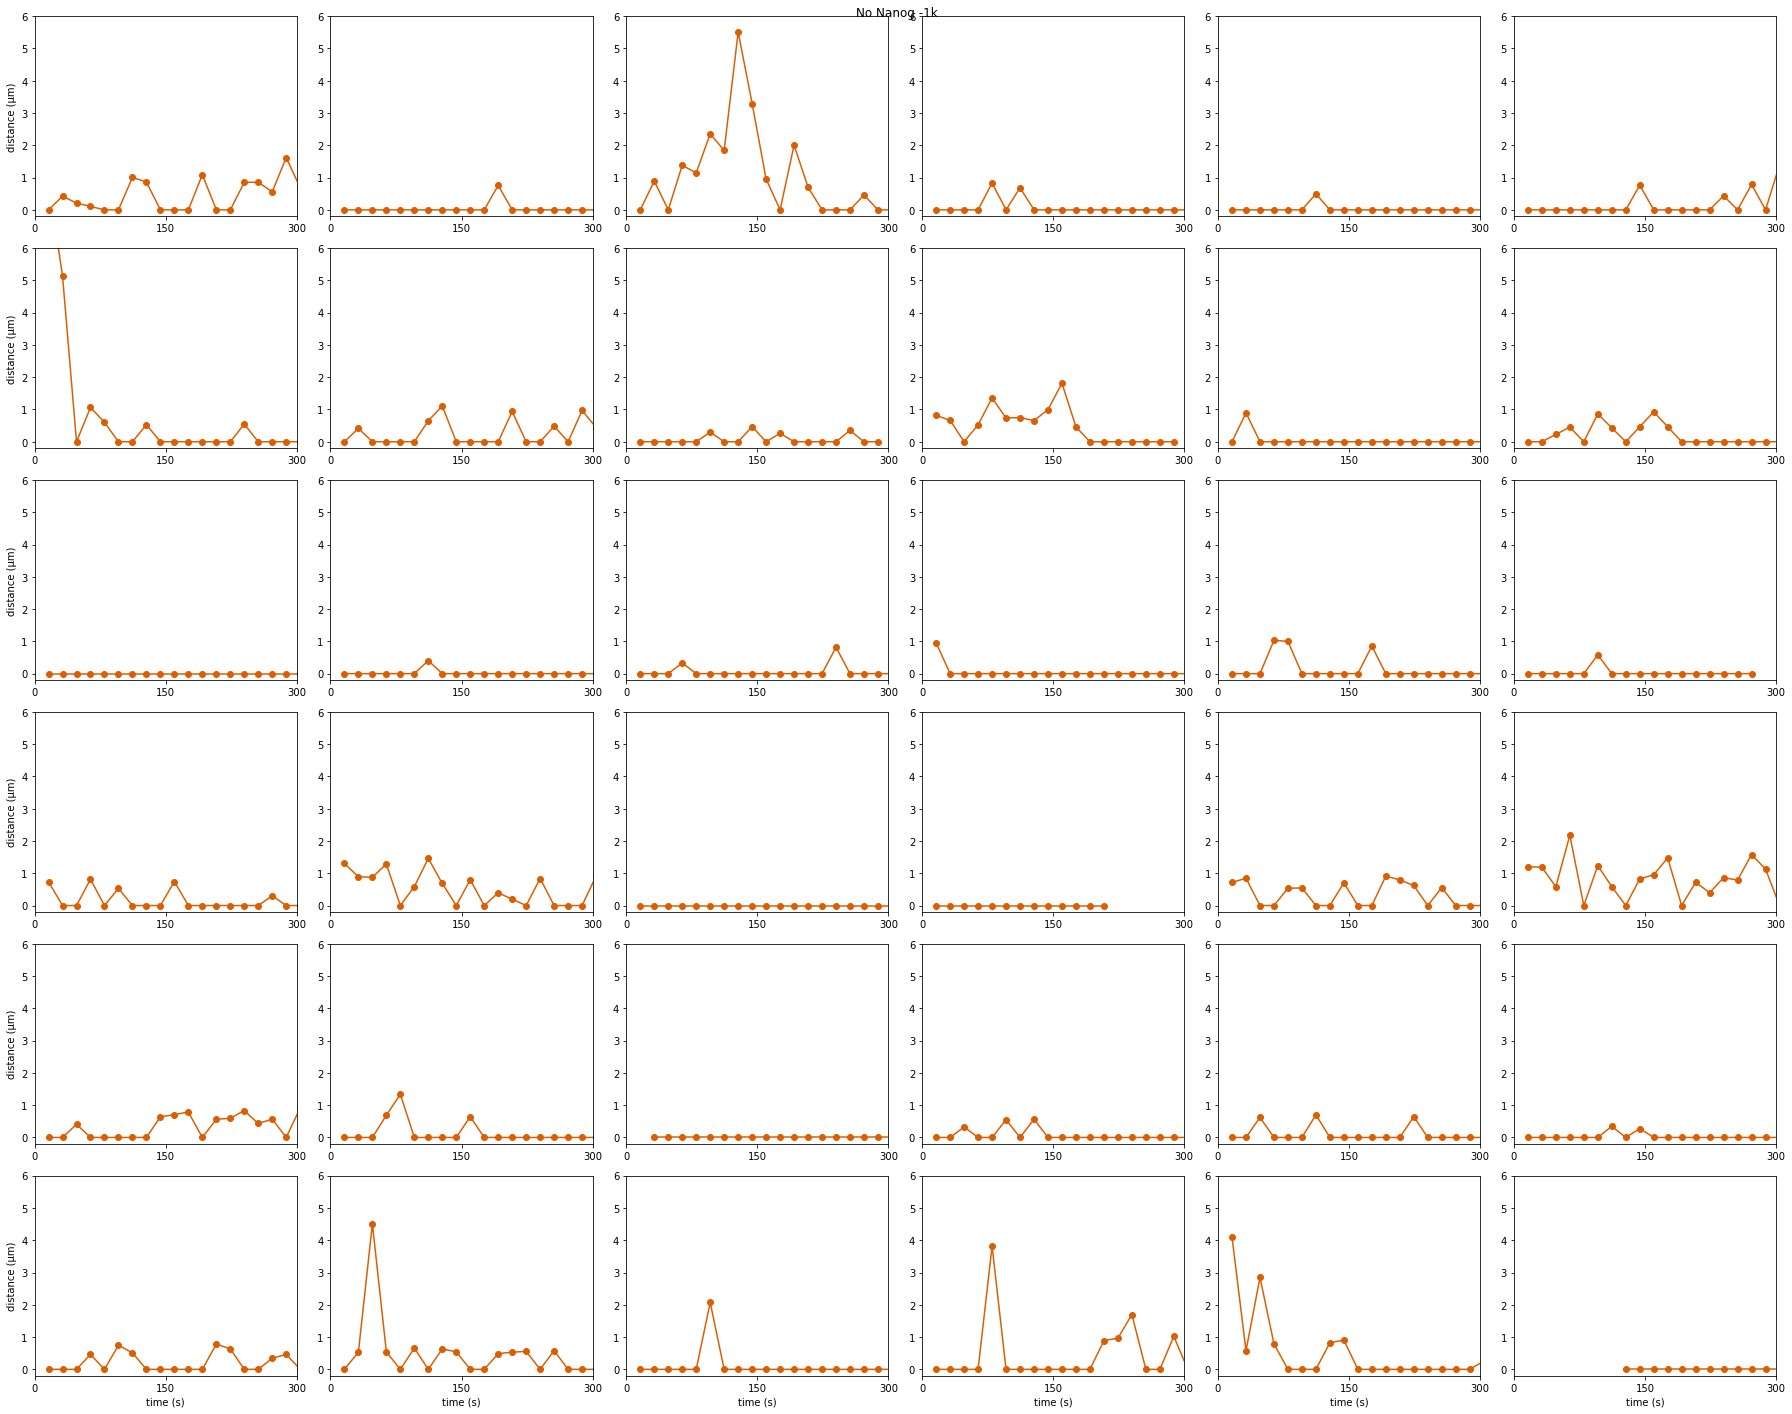

In [24]:
# Plot No Nanog
grid_size = 1
while grid_size*grid_size < 30:
    grid_size = grid_size+1
    
fig, ax = plt.subplots(ncols=grid_size,nrows=grid_size,figsize=(25,20))

for i in range(min(grid_size*grid_size,len(dict_no_nanog[stage]["Time(s)"]))):
    ax[int(i/grid_size),i%grid_size].plot(dict_no_nanog[stage]["Time(s)"][i],dict_no_nanog[stage][dist_metric][i],'-o',color=Cno_Nanog) 
    ax[int(i/grid_size),i%grid_size].set_ylim(-0.2,6)
    ax[int(i/grid_size),i%grid_size].set_xlim(0,300)
    ax[int(i/grid_size),i%grid_size].set_xticks([0,150,300])


for i in range(grid_size):
    ax[grid_size-1,i].set_xlabel('time (s)')
    ax[i,0].set_ylabel('distance (µm)')

plt.suptitle("No Nanog -%s"%stage)
plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# plt.savefig('SinglePlots_NoNanog'+'.pdf')
# plt.savefig('SinglePlots_NoNanog'+'.png')
plt.show()

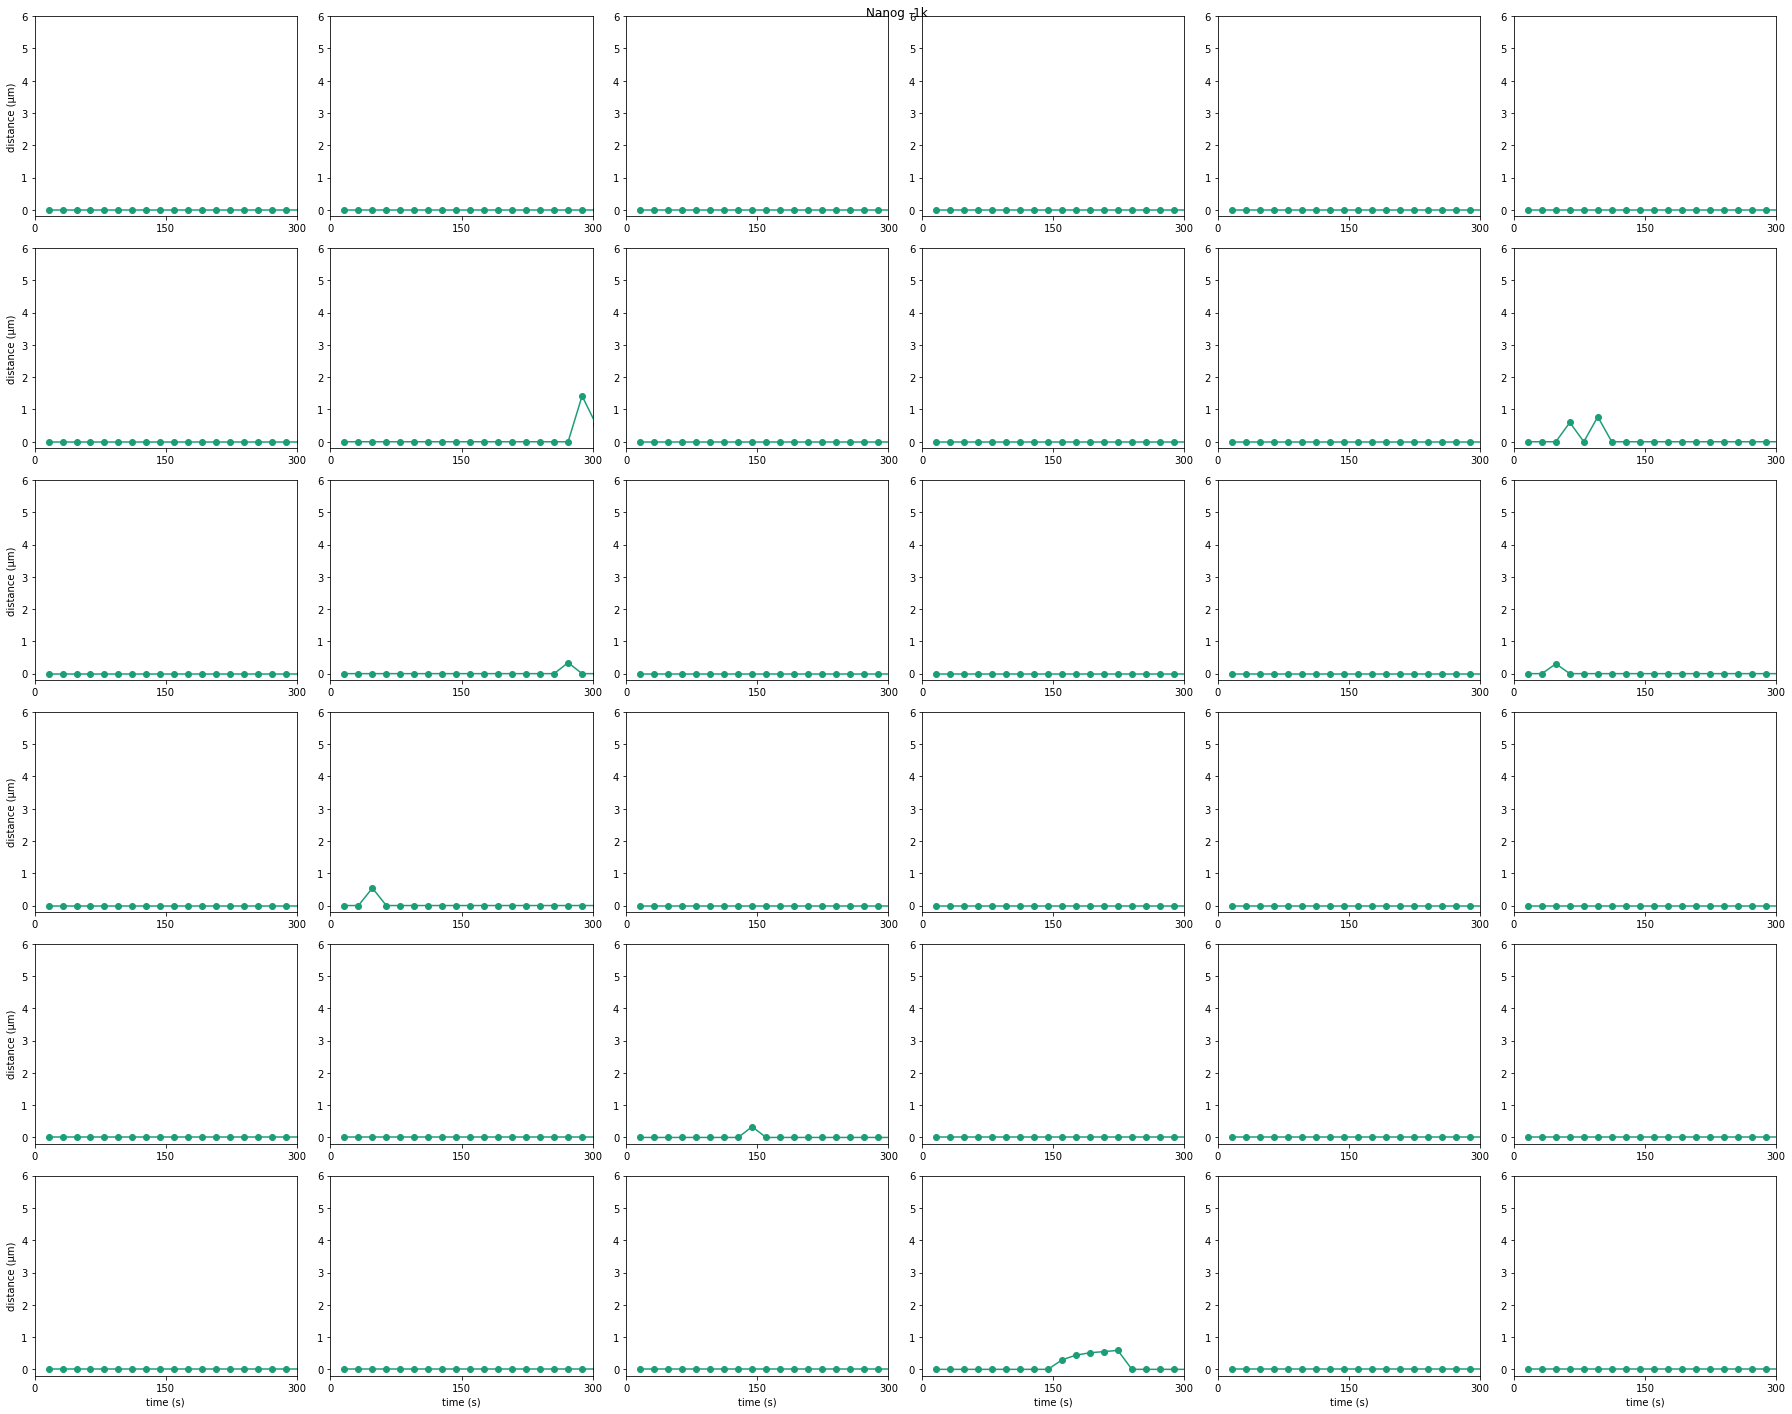

In [25]:
# Plot Nanog
grid_size = 1
while grid_size*grid_size < 30:
    grid_size = grid_size+1
    
    
fig, ax = plt.subplots(ncols=grid_size,nrows=grid_size,figsize=(25,20))

for i in range(min(grid_size*grid_size,len(dict_nanog[stage]["Time(s)"]))):
    ax[int(i/grid_size),i%grid_size].plot(dict_nanog[stage]["Time(s)"][i],dict_nanog[stage][dist_metric][i],'-o',color=Cnanog) 
    ax[int(i/grid_size),i%grid_size].set_ylim(-0.2,6)
    ax[int(i/grid_size),i%grid_size].set_xlim(0,300)
    ax[int(i/grid_size),i%grid_size].set_xticks([0,150,300])


for i in range(grid_size):
    ax[grid_size-1,i].set_xlabel('time (s)')
    ax[i,0].set_ylabel('distance (µm)')

plt.suptitle("Nanog -%s"%stage)
plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# plt.savefig('SinglePlots_Nanog'+'.pdf')
# plt.savefig('SinglePlots_Nanog'+'.png')
plt.show()

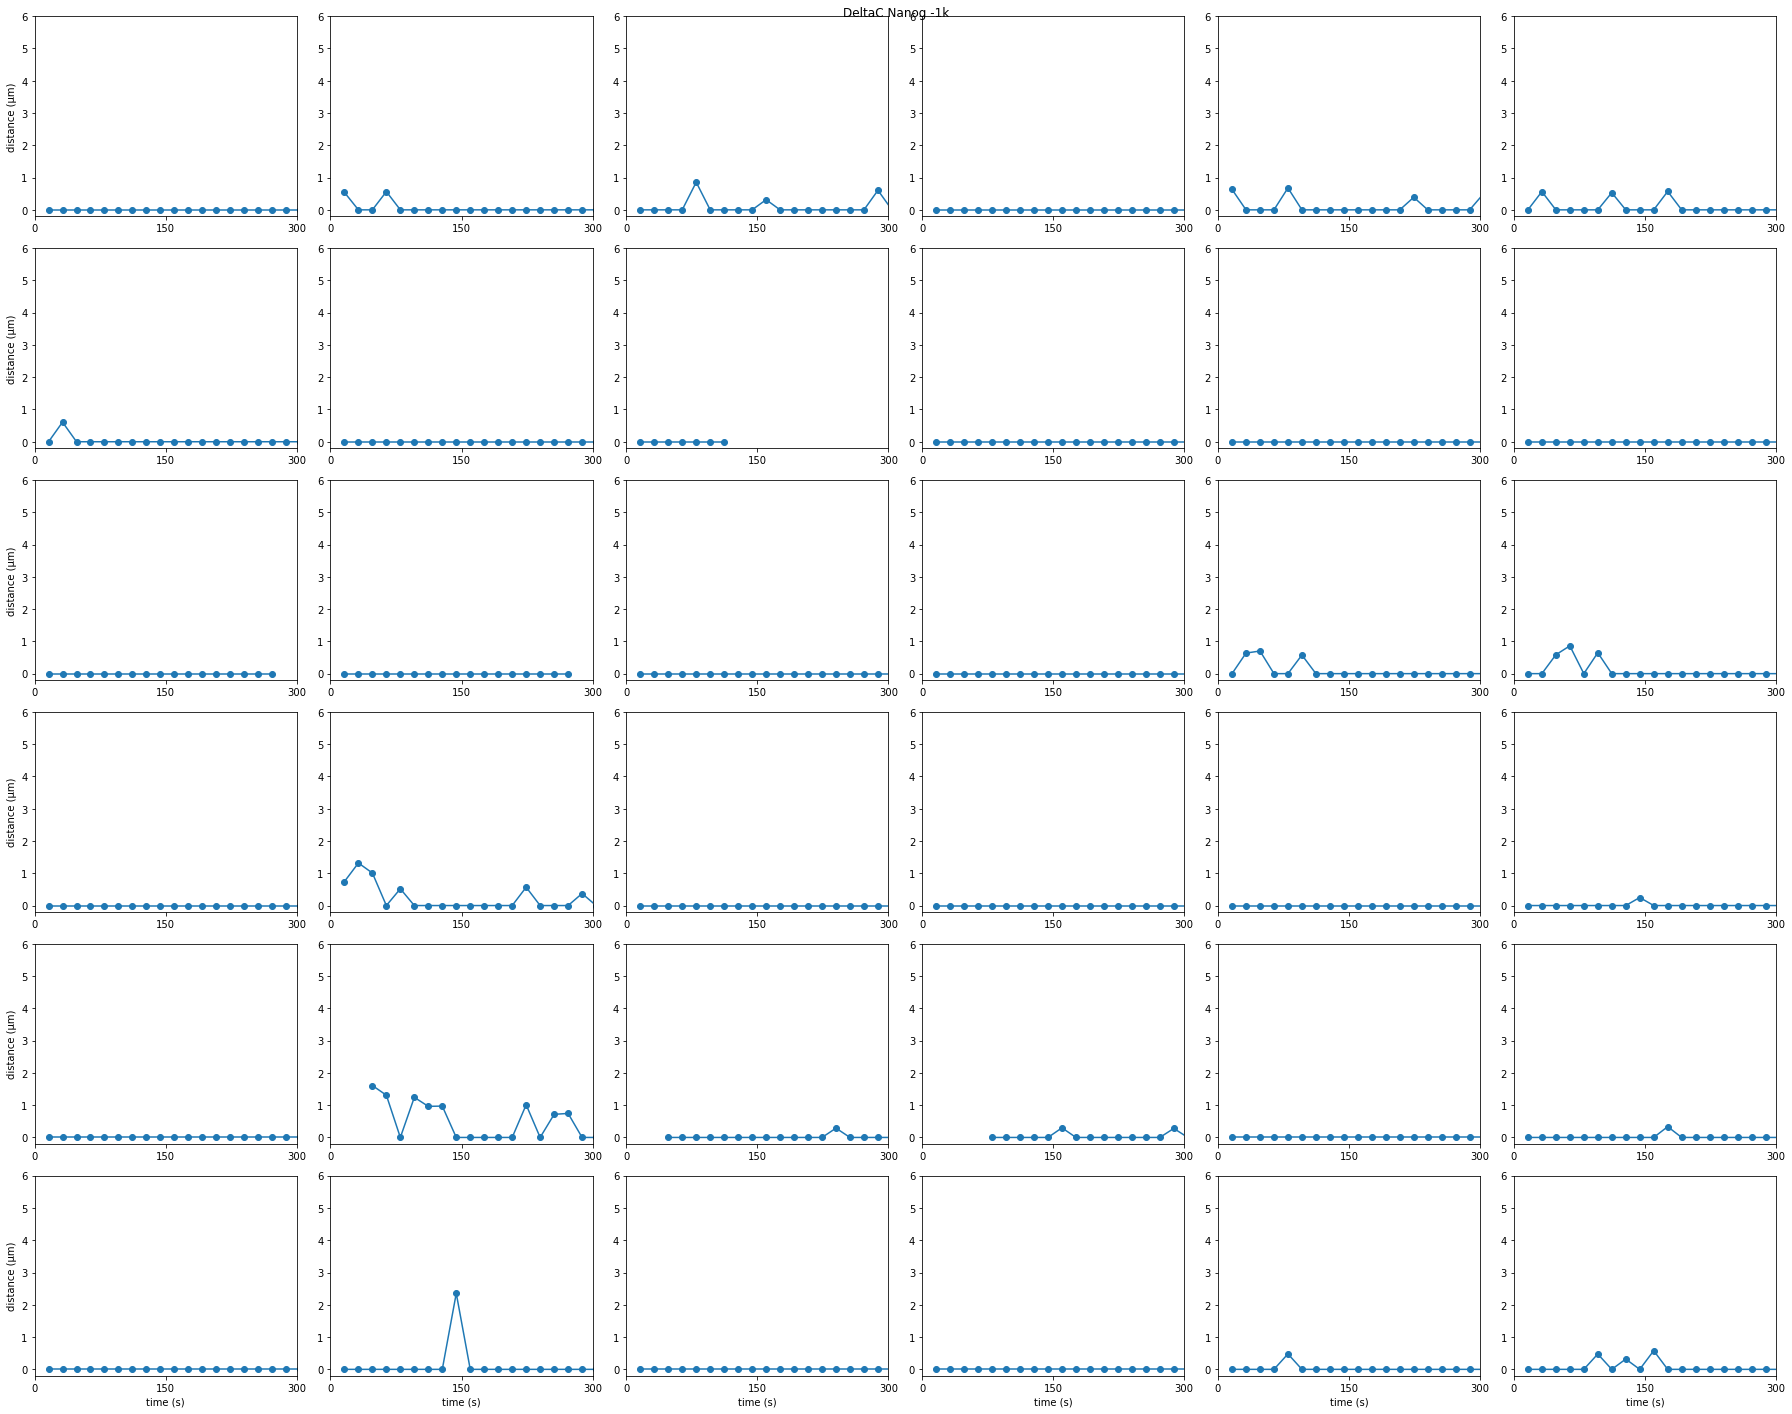

In [26]:
# Plot DeltaC Nanog
grid_size = 1
while grid_size*grid_size < 30:
    grid_size = grid_size+1

fig, ax = plt.subplots(ncols=grid_size,nrows=grid_size,figsize=(25,20))

for i in range(min(grid_size*grid_size,len(dict_DeltaC[stage]["Time(s)"]))):
    ax[int(i/grid_size),i%grid_size].plot(dict_DeltaC[stage]["Time(s)"][i],dict_DeltaC[stage][dist_metric][i],'-o',color=CdeltaC) 
    ax[int(i/grid_size),i%grid_size].set_ylim(-0.2,6)
    ax[int(i/grid_size),i%grid_size].set_xlim(0,300)
    ax[int(i/grid_size),i%grid_size].set_xticks([0,150,300])


for i in range(grid_size):
    ax[grid_size-1,i].set_xlabel('time (s)')
    ax[i,0].set_ylabel('distance (µm)')

plt.suptitle("DeltaC Nanog -%s"%stage)
plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# plt.savefig('SinglePlots_NanogC'+'.pdf')
# plt.savefig('SinglePlots_NanogC'+'.png')
plt.show()

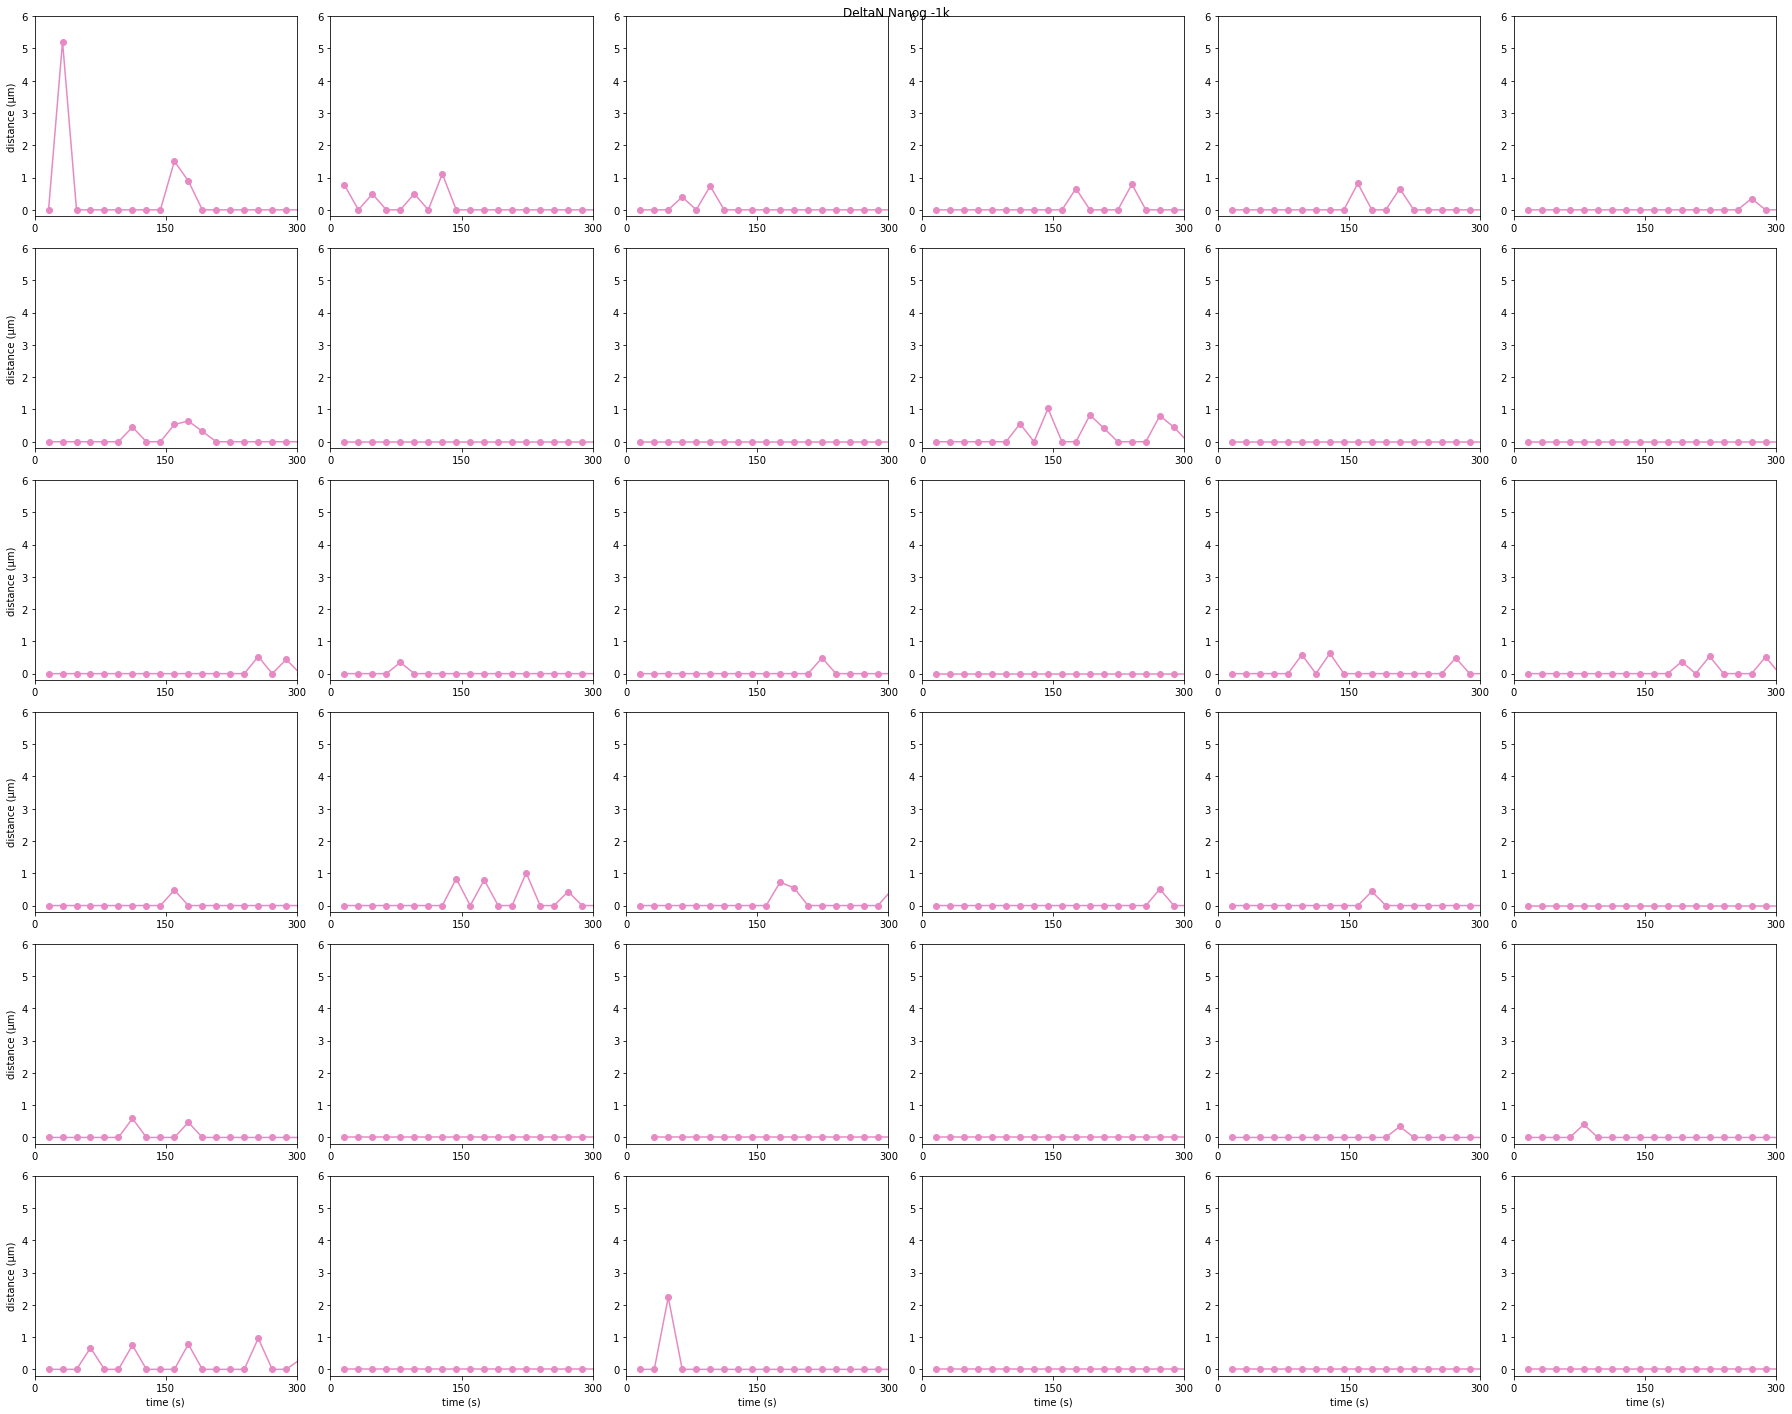

In [27]:
# Plot DeltaN Nanog
grid_size = 1
while grid_size*grid_size < 30:
    grid_size = grid_size+1

fig, ax = plt.subplots(ncols=grid_size,nrows=grid_size,figsize=(25,20))

for i in range(min(grid_size*grid_size,len(dict_DeltaN[stage]["Time(s)"]))):
    ax[int(i/grid_size),i%grid_size].plot(dict_DeltaN[stage]["Time(s)"][i],dict_DeltaN[stage][dist_metric][i],'-o',color=CdeltaN) 
    ax[int(i/grid_size),i%grid_size].set_ylim(-0.2,6)
    ax[int(i/grid_size),i%grid_size].set_xlim(0,300)
    ax[int(i/grid_size),i%grid_size].set_xticks([0,150,300])


for i in range(grid_size):
    ax[grid_size-1,i].set_xlabel('time (s)')
    ax[i,0].set_ylabel('distance (µm)')

plt.suptitle("DeltaN Nanog -%s"%stage)
plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# plt.savefig('SinglePlots_NanogN'+'.pdf')
# plt.savefig('SinglePlots_NanogN'+'.png')
plt.show()

# 5. Hypothesis testing

In [28]:
# Choose stage and metric
stages_to_check = ["All stages", "1k"]
dist_metrics_to_check = ["BaryDist(um)", "MaxDist(um)"]
speed_metrics_to_check = ["SpeedBary(um/s)", "SpeedMax(um/s)"]

In [29]:
stats_table = pd.DataFrame(columns = ['Measure', 'Metric' ,'Stage', 'p-value'])

## 5.1 Number of oscillations

p-value Mann-Whitney U test for stage 1k: 0.000013


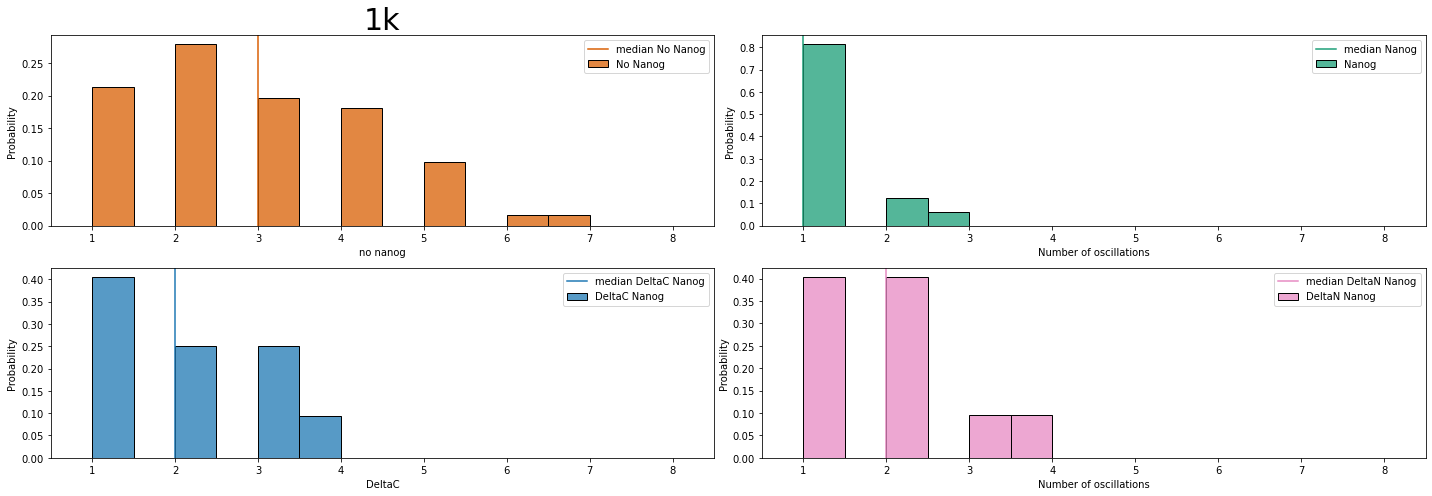

In [30]:
# Histograms of number of oscillations
fig, axs = plt.subplots(ncols=2,nrows=2,figsize=(20,7))

    # Get number of oscillations
oscill_nanog = dict_nanog["1k"]["Oscillations"]
oscill_no_nanog = dict_no_nanog["1k"]["Oscillations"]
oscill_DeltaC = dict_DeltaC["1k"]["Oscillations"]
oscill_DeltaN = dict_DeltaN["1k"]["Oscillations"]


        # Statistical test for Nanog and no Nanog
U, p_mw = stats.mannwhitneyu(oscill_no_nanog,oscill_nanog,alternative="greater")
print("p-value Mann-Whitney U test for stage %s: %f"%(stage,p_mw))
    
stats_table = pd.concat([stats_table, pd.DataFrame({
'Measure': ["number of oscillations"],  # Wrap scalar values in lists
'Metric': ["-"],
'Stage': [stage],  # Ensure stage is a list
'p-value': [p_mw]  # Wrap p_mw in a list if it's a scalar
})], ignore_index=True)

    # Plot histograms
axs[0, 0].set_title("1k", fontsize=30)
sns.histplot(ax=axs[0,1], data=pd.DataFrame({"nanog": oscill_nanog}), x="nanog", stat="probability", bins=4, color=Cnanog, label="Nanog", binwidth=0.5)
sns.histplot(ax=axs[0,0],data=pd.DataFrame({"no nanog":oscill_no_nanog})["no nanog"],stat="probability",bins=4,color=Cno_Nanog,label = "No Nanog",binwidth=0.5)
sns.histplot(ax=axs[1,0],data=pd.DataFrame({"DeltaC":oscill_DeltaC})["DeltaC"],stat="probability",bins=4,color=CdeltaC,label = "DeltaC Nanog",binwidth=0.5)
sns.histplot(ax=axs[1,1],data=pd.DataFrame({"DeltaN":oscill_DeltaN})["DeltaN"],stat="probability",bins=4,color=CdeltaN,label = "DeltaN Nanog",binwidth=0.5)
axs[0,1].set_xlabel("Number of oscillations")
axs[1,1].set_xlabel("Number of oscillations")
axs[0,1].axvline(x=np.median(oscill_nanog),color=Cnanog,linestyle='-',label="median Nanog")
axs[0,0].axvline(x=np.median(oscill_no_nanog),color=Cno_Nanog,linestyle='-',label="median No Nanog")
axs[1,0].axvline(x=np.median(oscill_DeltaC),color=CdeltaC,linestyle='-',label="median DeltaC Nanog")
axs[1,1].axvline(x=np.median(oscill_DeltaN),color=CdeltaN,linestyle='-',label="median DeltaN Nanog")
axs[0,0].legend()
axs[0,1].legend()
axs[1,0].legend()
axs[1,1].legend()
axs[0,0].set_xlim([0.5,8.5])
axs[0,1].set_xlim([0.5,8.5])
axs[1,0].set_xlim([0.5,8.5])
axs[1,1].set_xlim([0.5,8.5])
plt.tight_layout()

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# plt.savefig('Oscillations'+'.pdf')
# plt.savefig('Oscillations'+'.png')
plt.show()

In [31]:
pairs = [(oscill_nanog, oscill_no_nanog), (oscill_nanog, oscill_DeltaC), (oscill_nanog, oscill_DeltaN), (oscill_no_nanog, oscill_DeltaC), (oscill_no_nanog, oscill_DeltaN), (oscill_DeltaC, oscill_DeltaN)]
# Generate annotations with significance highlighting
formatted_annotations = []
for i, (d1, d2) in enumerate(pairs):
    u_stat, p_median = stats.mannwhitneyu(d1, d2)
    # ks_stat, p_dist = stats.ks_2samp(d1, d2)
    if p_median < 0.05 :
        formatted_annotations.append(f"Pair {i+1}: MW p={p_median:.3e}* (Significant)*")
    else:
        formatted_annotations.append(f"Pair {i+1}: MW p={p_median:.3e},(Not Significant)")


for annotation in formatted_annotations:
    print(annotation)

Pair 1: MW p=2.679e-05* (Significant)*
Pair 2: MW p=7.020e-03* (Significant)*
Pair 3: MW p=8.241e-03* (Significant)*
Pair 4: MW p=1.641e-02* (Significant)*
Pair 5: MW p=1.075e-03* (Significant)*
Pair 6: MW p=5.630e-01,(Not Significant)


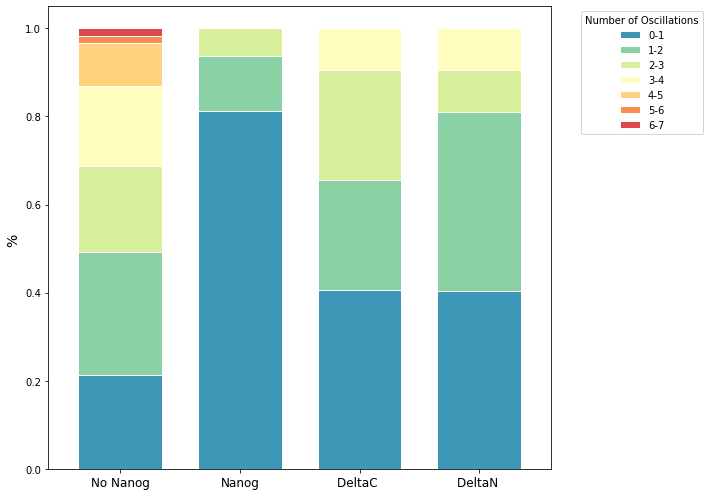

In [32]:
# Prepare the data
data_dict = {
    "No Nanog": dict_no_nanog["1k"]["Oscillations"],
    "Nanog": dict_nanog["1k"]["Oscillations"],
    "DeltaC ": dict_DeltaC["1k"]["Oscillations"],
    "DeltaN ": dict_DeltaN["1k"]["Oscillations"],
}

bins = np.arange(0.1, 8, 1)  # Define bin edges
binned_data = {key: np.histogram(values, bins=bins)[0] for key, values in data_dict.items()}
stacked_data = pd.DataFrame(binned_data, index=[f"{int(b)}-{int(b+1)}" for b in bins[:-1]])

stacked_data_prob = stacked_data.div(stacked_data.sum(axis=0), axis=1)
stacked_data_prob.T.plot(
    kind="bar", stacked=True, figsize=(10, 7), 
    color=sns.color_palette("Spectral_r",  len(stacked_data_prob)),edgecolor = 'white', width = 0.7
)


plt.ylabel("% ", fontsize=14)
# plt.xlabel("Condition", fontsize=14)
# plt.title("Stacked Bar Plot of Oscillations by Condition", fontsize=16)
plt.xticks(rotation=0, fontsize=12)
plt.legend(title="Number of Oscillations", fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the plot
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# plt.savefig("Oscillations_StackedBar_ByCondition.pdf")
# plt.savefig("Oscillations_StackedBar_ByCondition.png")
plt.show()


## 5.2 Hypothesis test for "motor hypothesis"

### Distances in unbound state

p-value Mann-Whitney U test: 0.969017
p-value Mann-Whitney U test: 0.969017
p-value Mann-Whitney U test: 0.961365
p-value Mann-Whitney U test: 0.961365


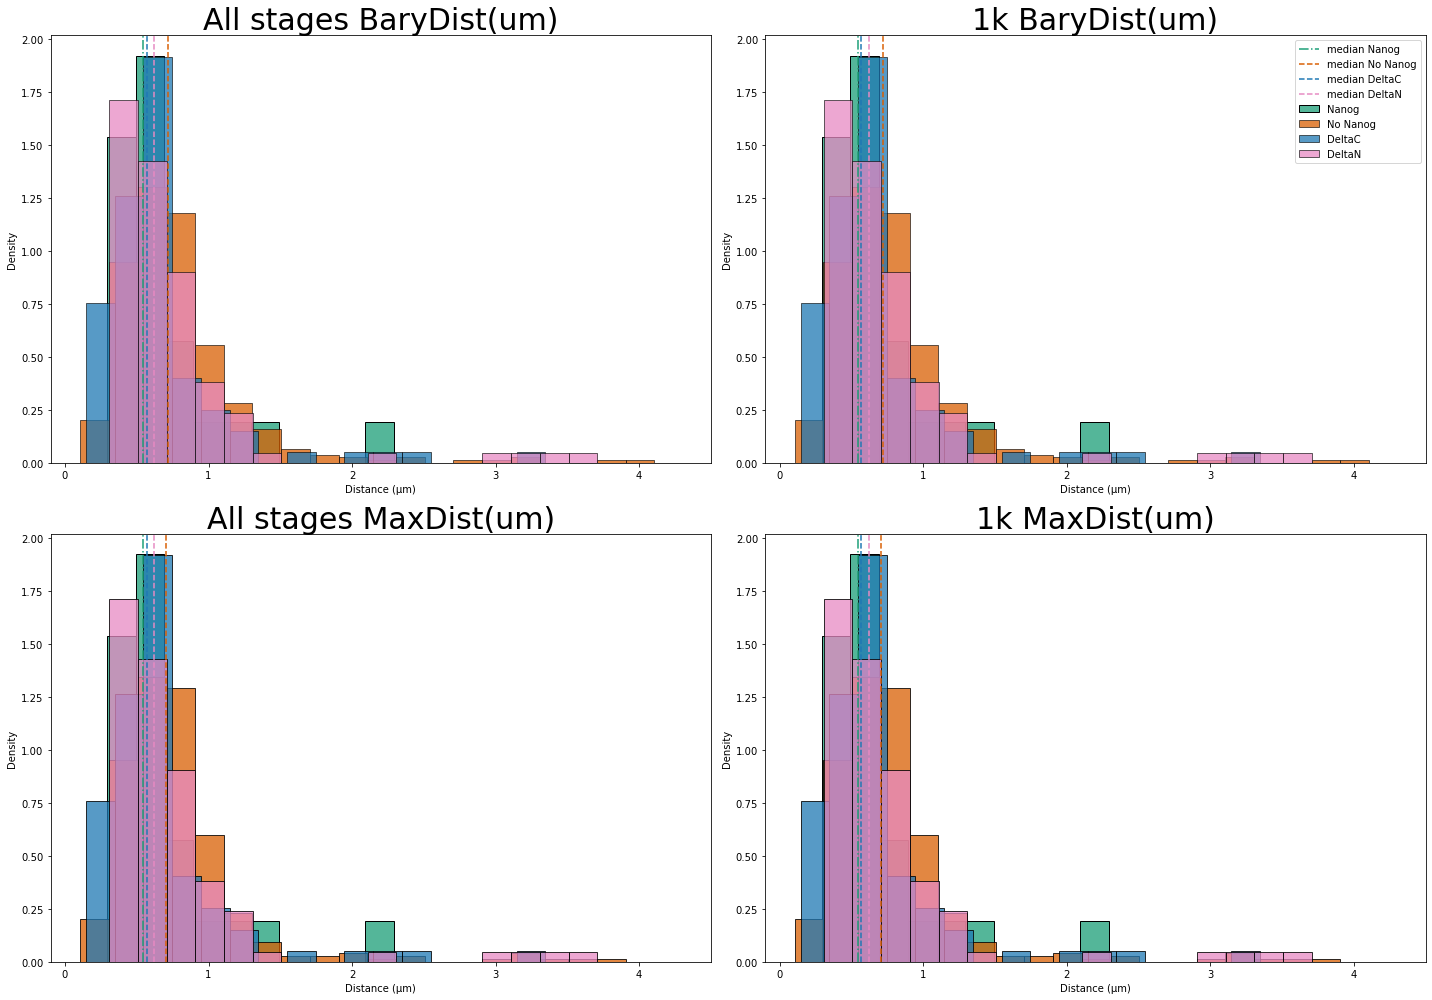

Median No Nanog, Nanog and DeltaC: 0.7060963444389541, 0.5459248975577109, 0.5694251487244121, 0.6214249753588833


In [33]:
fig, axs = plt.subplots(ncols=len(stages_to_check),nrows=len(dist_metrics_to_check),figsize=(10*len(stages_to_check),7*len(dist_metrics_to_check)))
i = 0
for dist_metric in dist_metrics_to_check:
    j=0
    for stage in stages_to_check:

        # Get distances
        dist_unbound_nanog = flatten_list(dict_nanog[stage][dist_metric])
        dist_unbound_nanog = [dist for dist in dist_unbound_nanog if dist > 0]
        dist_unbound_no_nanog = flatten_list(dict_no_nanog[stage][dist_metric])
        dist_unbound_no_nanog = [dist for dist in dist_unbound_no_nanog if dist > 0]
        dist_unbound_DeltaC = flatten_list(dict_DeltaC[stage][dist_metric])
        dist_unbound_DeltaC = [dist for dist in dist_unbound_DeltaC if dist > 0]
        dist_unbound_DeltaN = flatten_list(dict_DeltaN[stage][dist_metric])
        dist_unbound_DeltaN = [dist for dist in dist_unbound_DeltaN if dist > 0]
        
        # Statistical test for Nanog and no Nanog
        U1, p_mw = stats.mannwhitneyu(dist_unbound_nanog,dist_unbound_no_nanog,alternative="greater")
        print("p-value Mann-Whitney U test: %f"%p_mw)
        stats_table = stats_table.append({'Measure' : "distance", 'Metric' : dist_metric,'Stage' : stage, 'p-value':p_mw},ignore_index=True)

        stats_table = pd.concat([stats_table, pd.DataFrame({
                        'Measure': ["distance "],  # Wrap scalar values in lists
                        'Metric': [dist_metric],
                        'Stage': [stage],  # Ensure stage is a list
                        'p-value': [p_mw]  # Wrap p_mw in a list if it's a scalar
                        })], ignore_index=True)

        sns.histplot(ax=axs[i,j], data=pd.DataFrame({"nanog":dist_unbound_nanog})["nanog"],stat="density",color=Cnanog,label="Nanog",binwidth=0.2)
        sns.histplot(ax=axs[i,j], data=pd.DataFrame({"no nanog":dist_unbound_no_nanog})["no nanog"],stat="density",color=Cno_Nanog,label = "No Nanog",binwidth=0.2)
        sns.histplot(ax=axs[i,j], data=pd.DataFrame({"DeltaC":dist_unbound_DeltaC})["DeltaC"],stat="density",color=CdeltaC,label = "DeltaC",binwidth=0.2)
        sns.histplot(ax=axs[i,j], data=pd.DataFrame({"DeltaN":dist_unbound_DeltaN})["DeltaN"],stat="density",color=CdeltaN,label = "DeltaN",binwidth=0.2)        
        axs[i,j].set_title(stage + " " + dist_metric, fontsize=30)
        axs[i,j].axvline(x=np.median(dist_unbound_nanog),color=Cnanog,linestyle='-.',label="median Nanog")
        axs[i,j].axvline(x=np.median(dist_unbound_no_nanog),color=Cno_Nanog,linestyle='--',label="median No Nanog")
        axs[i,j].axvline(x=np.median(dist_unbound_DeltaC),color=CdeltaC,linestyle='--',label="median DeltaC")
        axs[i,j].axvline(x=np.median(dist_unbound_DeltaN),color=CdeltaN,linestyle='--',label="median DeltaN")
        axs[i,j].set_xlabel("Distance (µm)")
        axs[i,j].set_xlim([-0.1,4.5])
        
        j+=1
    axs[i,j-1].set_ylabel("Density")
    i+=1
axs[0,1].legend()
plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# plt.savefig('Distances'+'.pdf')
# plt.savefig('Distances'+'.png')
plt.show()
print("Median No Nanog, Nanog and DeltaC: "+ str( np.median(dist_unbound_no_nanog)) +", " +  str( np.median(dist_unbound_nanog))+", "+ str( np.median(dist_unbound_DeltaC))+", "+ str( np.median(dist_unbound_DeltaN)))

In [43]:
# Choose stage and metric

dist_unbound_nanog = flatten_list(dict_nanog["1k"]["BaryDist(um)"])
dist_unbound_nanog = [dist for dist in dist_unbound_nanog if dist > 0]
dist_unbound_no_nanog = flatten_list(dict_no_nanog["1k"]["BaryDist(um)"])
dist_unbound_no_nanog = [dist for dist in dist_unbound_no_nanog if dist > 0]
dist_unbound_DeltaC = flatten_list(dict_DeltaC["1k"]["BaryDist(um)"])
dist_unbound_DeltaC = [dist for dist in dist_unbound_DeltaC if dist > 0]
dist_unbound_DeltaN = flatten_list(dict_DeltaN["1k"]["BaryDist(um)"])
dist_unbound_DeltaN = [dist for dist in dist_unbound_DeltaN if dist > 0]

print("Median No Nanog, Nanog: "+ str( np.median(dist_unbound_no_nanog)) +", " +  str( np.median(dist_unbound_nanog)))
print( str( np.median(dist_unbound_DeltaC))+", "+ str( np.median(dist_unbound_DeltaN)))


Median No Nanog, Nanog: 0.7210686084075932, 0.5459248975577109
0.5694251487244121, 0.6214249753588833


In [44]:
dist_unbound_nanog = flatten_list(dict_nanog["1k"]["MaxDist(um)"])
dist_unbound_nanog = [dist for dist in dist_unbound_nanog if dist > 0]
dist_unbound_no_nanog = flatten_list(dict_no_nanog["1k"]["MaxDist(um)"])
dist_unbound_no_nanog = [dist for dist in dist_unbound_no_nanog if dist > 0]
dist_unbound_DeltaC = flatten_list(dict_DeltaC["1k"]["MaxDist(um)"])
dist_unbound_DeltaC = [dist for dist in dist_unbound_DeltaC if dist > 0]
dist_unbound_DeltaN = flatten_list(dict_DeltaN["1k"]["MaxDist(um)"])
dist_unbound_DeltaN = [dist for dist in dist_unbound_DeltaN if dist > 0]

pairs = [(dist_unbound_nanog, dist_unbound_no_nanog), (dist_unbound_nanog, dist_unbound_DeltaC), (dist_unbound_nanog, dist_unbound_DeltaN), (dist_unbound_no_nanog, dist_unbound_DeltaC), (dist_unbound_no_nanog, dist_unbound_DeltaN), (dist_unbound_DeltaC, dist_unbound_DeltaN)]
# Generate annotations with significance highlighting
formatted_annotations = []
for i, (d1, d2) in enumerate(pairs):
    u_stat, p_median = stats.mannwhitneyu(d1, d2)
    # ks_stat, p_dist = stats.ks_2samp(d1, d2)
    if p_median < 0.05 :
        formatted_annotations.append(f"Pair {i+1}: MW p={p_median:.3e}* (Significant)*")
    else:
        formatted_annotations.append(f"Pair {i+1}: MW p={p_median:.3e} (Not Significant)")

# Print the formatted annotations
for annotation in formatted_annotations:
    print(annotation)

Pair 1: MW p=7.757e-02 (Not Significant)
Pair 2: MW p=9.685e-01 (Not Significant)
Pair 3: MW p=4.411e-01 (Not Significant)
Pair 4: MW p=2.004e-04* (Significant)*
Pair 5: MW p=5.066e-02 (Not Significant)
Pair 6: MW p=1.331e-01 (Not Significant)


### Speed to come together from max

p-value Mann-Whitney U test: 0.590575
p-value Mann-Whitney U test: 0.590575
p-value Mann-Whitney U test: 0.565572
p-value Mann-Whitney U test: 0.565572


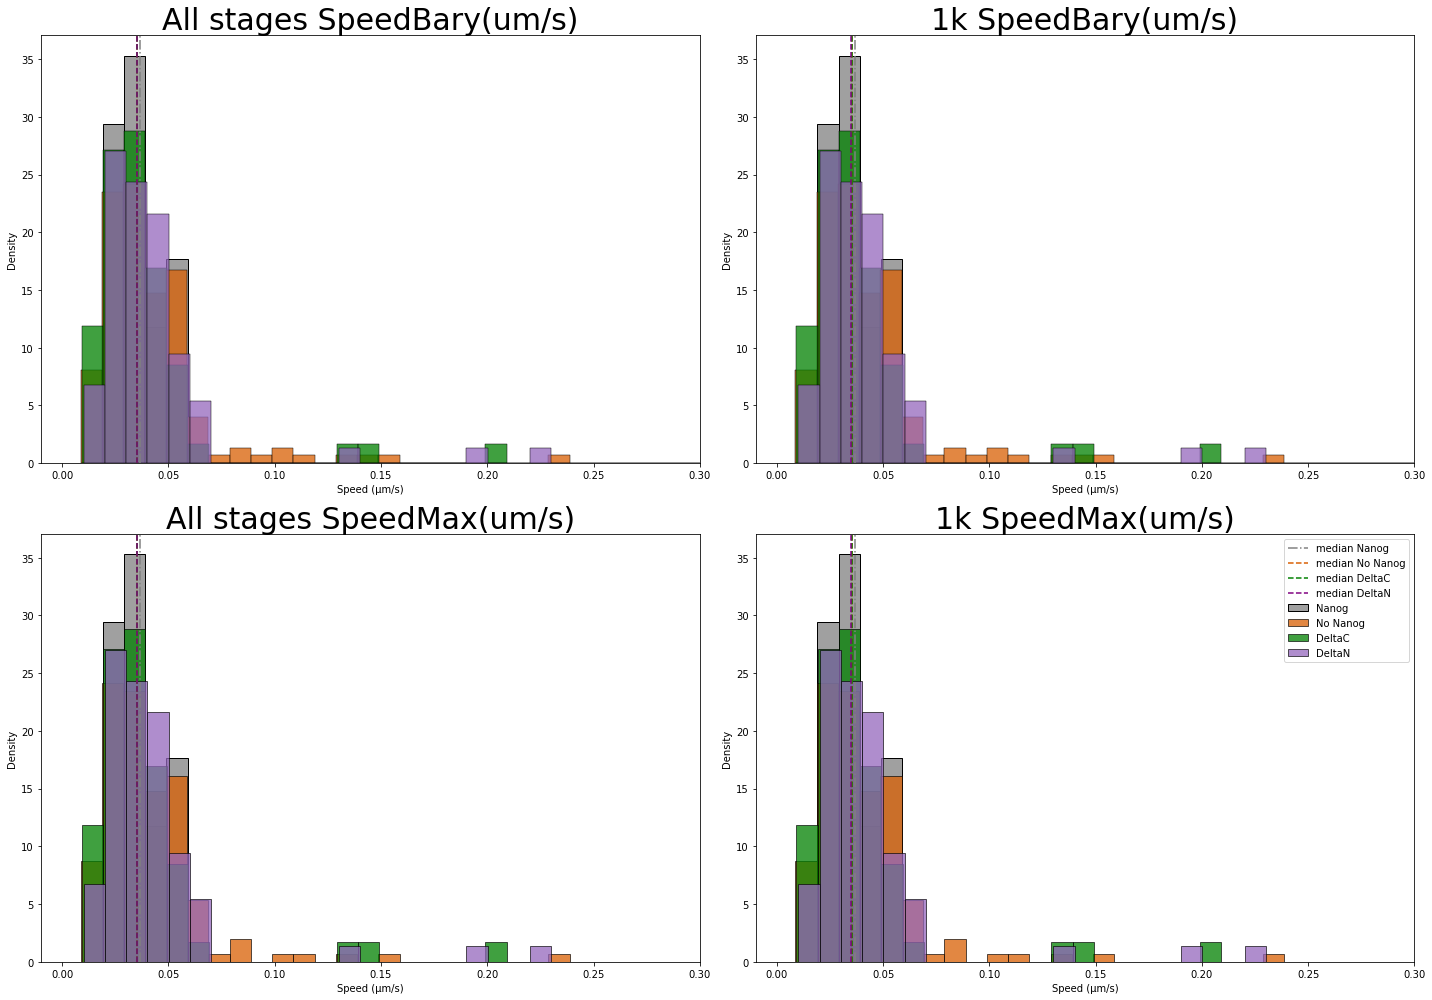

In [35]:
fig, axs = plt.subplots(ncols=len(stages_to_check),nrows=len(speed_metrics_to_check),figsize=(10*len(stages_to_check),7*len(dist_metrics_to_check)))

i = 0
for speed_metric in speed_metrics_to_check:
    j=0
    for stage in stages_to_check:

        # Get speeds to come together from max distance
        v_nanog = dict_nanog[stage][speed_metric]
        v_no_nanog = dict_no_nanog[stage][speed_metric]
        v_DeltaC = dict_DeltaC[stage][speed_metric]
        v_DeltaN = dict_DeltaN[stage][speed_metric]

        # Statistical test for Nanog and no Nanog
        U1, p_mw = stats.mannwhitneyu(v_nanog,v_no_nanog,alternative="greater")
        print("p-value Mann-Whitney U test: %f"%p_mw)
        stats_table = stats_table.append({'Measure' : "speed to come together from max", 'Metric' : speed_metric,'Stage' : stage, 'p-value':p_mw},ignore_index=True)

        stats_table = pd.concat([stats_table, pd.DataFrame({
                        'Measure': ["speed to come together from max"],  # Wrap scalar values in lists
                        'Metric': [speed_metric],
                        'Stage': [stage],  # Ensure stage is a list
                        'p-value': [p_mw]  # Wrap p_mw in a list if it's a scalar
                        })], ignore_index=True)

        sns.histplot(ax=axs[i,j], data=pd.DataFrame({"nanog":v_nanog})["nanog"],stat="density", common_bins = True,color="grey",label="Nanog",binwidth=0.01)
        sns.histplot(ax=axs[i,j], data=pd.DataFrame({"no nanog":v_no_nanog})["no nanog"],stat="density",color=Cno_Nanog,label = "No Nanog",binwidth=0.01)
        sns.histplot(ax=axs[i,j], data=pd.DataFrame({"DeltaC":v_DeltaC})["DeltaC"],stat="density",color="green",label = "DeltaC",binwidth=0.01)
        sns.histplot(ax=axs[i,j], data=pd.DataFrame({"DeltaN":v_DeltaN})["DeltaN"],stat="density",color="tab:purple",label = "DeltaN",binwidth=0.01)
        axs[i,j].set_title(stage + " " + speed_metric, fontsize=30)
        axs[i,j].axvline(x=np.median(v_nanog),color="grey",linestyle='-.',label="median Nanog")
        axs[i,j].axvline(x=np.median(v_no_nanog),color=Cno_Nanog,linestyle='--',label="median No Nanog")
        axs[i,j].axvline(x=np.median(v_DeltaC),color="green",linestyle='--',label="median DeltaC")
        axs[i,j].axvline(x=np.median(v_DeltaN),color="purple",linestyle='--',label="median DeltaN")
        axs[i,j].set_xlabel("Speed (µm/s)")
        axs[i,j].set_xlim([-0.01, 0.3])
        
        j+=1
    i+=1
axs[i-1,j-1].legend()
plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# plt.savefig('Speed_all'+'.pdf')
# plt.savefig('Speed_all'+'.png')
plt.show()
   

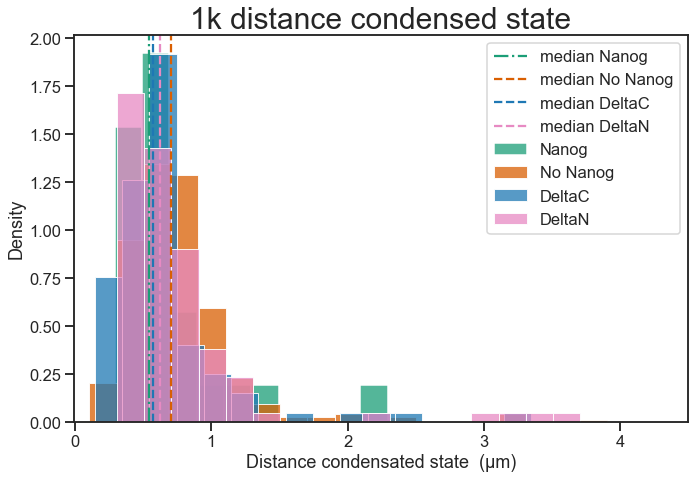

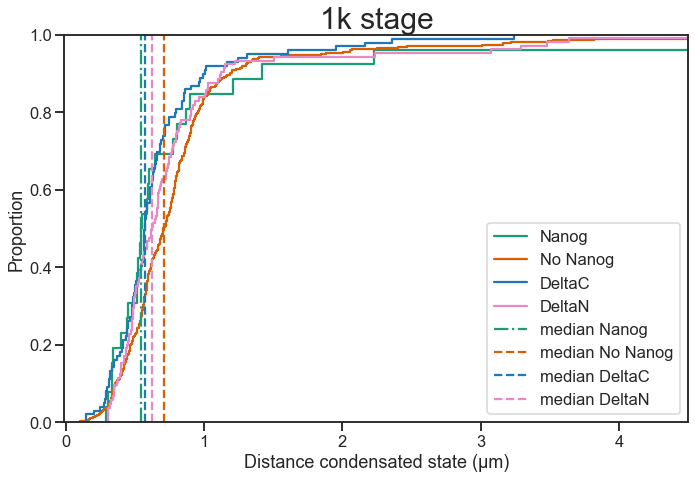

In [36]:
fig= plt.figure(figsize=(10,7))

# Distribution of the maximum distance of the loci for 1k  
dist_unbound_nanog = flatten_list(dict_nanog["1k"]["MaxDist(um)"])
dist_unbound_nanog = [dist for dist in dist_unbound_nanog if dist > 0]
dist_unbound_no_nanog = flatten_list(dict_no_nanog["1k"]["MaxDist(um)"])
dist_unbound_no_nanog = [dist for dist in dist_unbound_no_nanog if dist > 0]
dist_unbound_DeltaC = flatten_list(dict_DeltaC["1k"]["MaxDist(um)"])
dist_unbound_DeltaC = [dist for dist in dist_unbound_DeltaC if dist > 0]
dist_unbound_DeltaN = flatten_list(dict_DeltaN["1k"]["MaxDist(um)"])
dist_unbound_DeltaN = [dist for dist in dist_unbound_DeltaN if dist > 0]

color = sns.color_palette("Set2")
sns.set_style("white")
sns.set_context("talk")
sns.set_style("ticks")
sns.histplot(data=pd.DataFrame({"nanog":dist_unbound_nanog})["nanog"],stat="density",common_bins = True,color=Cnanog, label="Nanog",binwidth=0.2)
sns.histplot( data=pd.DataFrame({"no nanog":dist_unbound_no_nanog})["no nanog"],stat="density",color=Cno_Nanog,label = "No Nanog",binwidth=0.2)
sns.histplot(data=pd.DataFrame({"DeltaC":dist_unbound_DeltaC})["DeltaC"],stat="density",color=CdeltaC,label = "DeltaC",binwidth=0.2)
sns.histplot(data=pd.DataFrame({"DeltaN":dist_unbound_DeltaN})["DeltaN"],stat="density",color=CdeltaN, label = "DeltaN",binwidth=0.2)

 
plt.title( "1k distance condensed state", fontsize=30)
plt.axvline(x=np.median(dist_unbound_nanog),color=Cnanog,linestyle='-.',label="median Nanog")
plt.axvline(x=np.median(dist_unbound_no_nanog),color=Cno_Nanog,linestyle='--',label="median No Nanog")
plt.axvline(x=np.median(dist_unbound_DeltaC),color=CdeltaC,linestyle='--',label="median DeltaC")
plt.axvline(x=np.median(dist_unbound_DeltaN),color=CdeltaN,linestyle='--',label="median DeltaN")
plt.xlabel("Distance condensated state  (µm)")
plt.xlim([-0.01, 4.5])

plt.legend()
plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# plt.savefig('Dist1k'+'.pdf')
# plt.savefig('Dist1k'+'.png')
plt.show()

fig= plt.figure(figsize=(10,7))

# Comulative distribution of the maximum distance of the loci for 1k  
color = sns.color_palette("Set2")
sns.set_style("white")
sns.set_context("talk")
sns.set_style("ticks")
sns.ecdfplot(data=pd.DataFrame({"nanog":dist_unbound_nanog})["nanog"],stat="proportion", color=Cnanog, label="Nanog")
sns.ecdfplot( data=pd.DataFrame({"no nanog":dist_unbound_no_nanog})["no nanog"],stat="proportion",color=Cno_Nanog,label = "No Nanog")
sns.ecdfplot(data=pd.DataFrame({"DeltaC":dist_unbound_DeltaC})["DeltaC"],stat="proportion",color=CdeltaC,label = "DeltaC")
sns.ecdfplot(data=pd.DataFrame({"DeltaN":dist_unbound_DeltaN})["DeltaN"],stat="proportion",color=CdeltaN, label = "DeltaN")
plt.xlim([-0.01, 4.5])

plt.title( "1k stage", fontsize=30)
plt.axvline(x=np.median(dist_unbound_nanog),color=Cnanog,linestyle='-.',label="median Nanog")
plt.axvline(x=np.median(dist_unbound_no_nanog),color=Cno_Nanog,linestyle='--',label="median No Nanog")
plt.axvline(x=np.median(dist_unbound_DeltaC),color=CdeltaC,linestyle='--',label="median DeltaC")
plt.axvline(x=np.median(dist_unbound_DeltaN),color=CdeltaN,linestyle='--',label="median DeltaN")
plt.xlabel("Distance condensated state (µm)")
plt.xlim([-0.01, 4.5])

plt.legend()
plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# plt.savefig('Distance1k_com'+'.pdf')
# plt.savefig('Distance1k_com'+'.png')
plt.show()


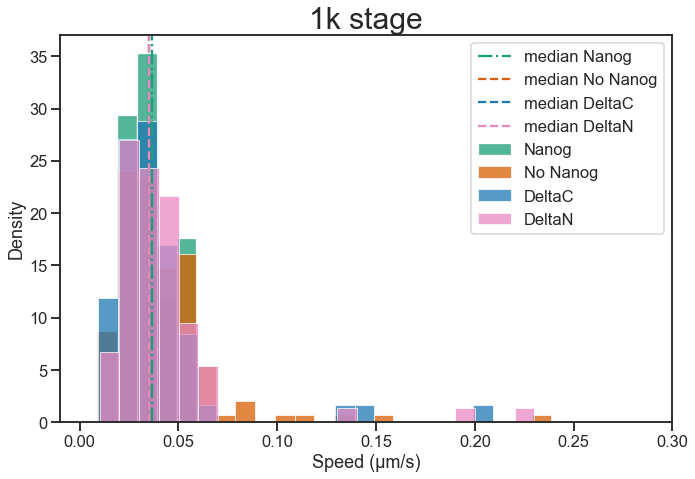

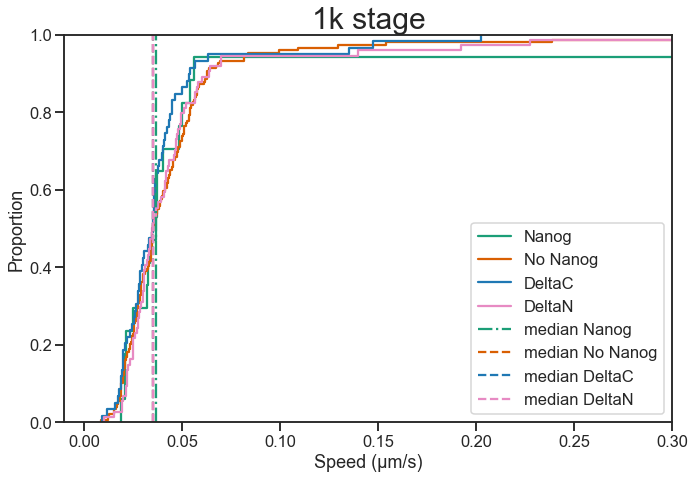

In [37]:
fig= plt.figure(figsize=(10,7))

# Get speeds to come together from max distance for 1k stage
v_nanog = dict_nanog["1k"]["SpeedMax(um/s)"]
v_no_nanog = dict_no_nanog["1k"]["SpeedMax(um/s)"]
v_DeltaC = dict_DeltaC["1k"]["SpeedMax(um/s)"]
v_DeltaN = dict_DeltaN["1k"]["SpeedMax(um/s)"]
color = sns.color_palette("deep")
sns.set_style("white")
sns.set_context("talk")
sns.set_style("ticks")
sns.histplot(data=pd.DataFrame({"nanog":v_nanog})["nanog"],stat="density",color=Cnanog, label="Nanog",binwidth=0.01)
sns.histplot( data=pd.DataFrame({"no nanog":v_no_nanog})["no nanog"],stat="density",color=Cno_Nanog,label = "No Nanog",binwidth=0.01)
sns.histplot(data=pd.DataFrame({"DeltaC":v_DeltaC})["DeltaC"],stat="density",color=CdeltaC,label = "DeltaC",binwidth=0.01)
sns.histplot(data=pd.DataFrame({"DeltaN":v_DeltaN})["DeltaN"],stat="density",color=CdeltaN, label = "DeltaN",binwidth=0.01)

 
plt.title( "1k stage", fontsize=30)
plt.axvline(x=np.median(v_nanog),color=Cnanog,linestyle='-.',label="median Nanog")
plt.axvline(x=np.median(v_no_nanog),color=Cno_Nanog,linestyle='--',label="median No Nanog")
plt.axvline(x=np.median(v_DeltaC),color=CdeltaC,linestyle='--',label="median DeltaC")
plt.axvline(x=np.median(v_DeltaN),color=CdeltaN,linestyle='--',label="median DeltaN")
plt.xlabel("Speed (µm/s)")
plt.xlim([-0.01, 0.3])

plt.legend()
plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# plt.savefig('Speed1k'+'.pdf')
# plt.savefig('Speed1k'+'.png')
plt.show()

fig= plt.figure(figsize=(10,7))
# Comulative distribution of the maximum speed to come together from max distance for 1k stage

v_nanog = dict_nanog["1k"]["SpeedMax(um/s)"]
v_no_nanog = dict_no_nanog["1k"]["SpeedMax(um/s)"]
v_DeltaC = dict_DeltaC["1k"]["SpeedMax(um/s)"]
v_DeltaN = dict_DeltaN["1k"]["SpeedMax(um/s)"]
sns.set_style("white")
sns.set_context("talk")
sns.set_style("ticks")
sns.ecdfplot(data=pd.DataFrame({"nanog":v_nanog})["nanog"],stat="proportion",color=Cnanog, label="Nanog")
sns.ecdfplot( data=pd.DataFrame({"no nanog":v_no_nanog})["no nanog"],stat="proportion",color=Cno_Nanog,label = "No Nanog")
sns.ecdfplot(data=pd.DataFrame({"DeltaC":v_DeltaC})["DeltaC"],stat="proportion",color=CdeltaC,label = "DeltaC")
sns.ecdfplot(data=pd.DataFrame({"DeltaN":v_DeltaN})["DeltaN"],stat="proportion",color=CdeltaN, label = "DeltaN")

 
plt.title( "1k stage", fontsize=30)
plt.axvline(x=np.median(v_nanog),color=Cnanog,linestyle='-.',label="median Nanog")
plt.axvline(x=np.median(v_no_nanog),color=Cno_Nanog,linestyle='--',label="median No Nanog")
plt.axvline(x=np.median(v_DeltaC),color=CdeltaC,linestyle='--',label="median DeltaC")
plt.axvline(x=np.median(v_DeltaN),color=CdeltaN,linestyle='--',label="median DeltaN")
plt.xlabel("Speed (µm/s)")
plt.xlim([-0.01, 0.3])

plt.legend()
plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# plt.savefig('Speed1k_com'+'.pdf')
# plt.savefig('Speed1k_com'+'.png')
plt.show()


In [38]:
v_nanog = dict_nanog["1k"]["SpeedMax(um/s)"]
v_no_nanog = dict_no_nanog["1k"]["SpeedMax(um/s)"]
v_DeltaC = dict_DeltaC["1k"]["SpeedMax(um/s)"]
v_DeltaN = dict_DeltaN["1k"]["SpeedMax(um/s)"]
print("Median No Nanog, Nanog and DeltaC: "+ str( np.median(v_no_nanog)) +", " +  str(np.median(v_nanog))+", "+ str( np.median(v_DeltaC))+", "+ str( np.median(v_DeltaN)))

Median No Nanog, Nanog and DeltaC: 0.0351939381321649, 0.03667935386561122, 0.035243682944602533, 0.03512442861248559


## 5.3 Hypothesis test for "glue hypothesis" - 1k and full dataset

### Time in condensed state excluding flat lines

p-value Mann-Whitney U test: 0.000341
p-value Mann-Whitney U test: 0.000341


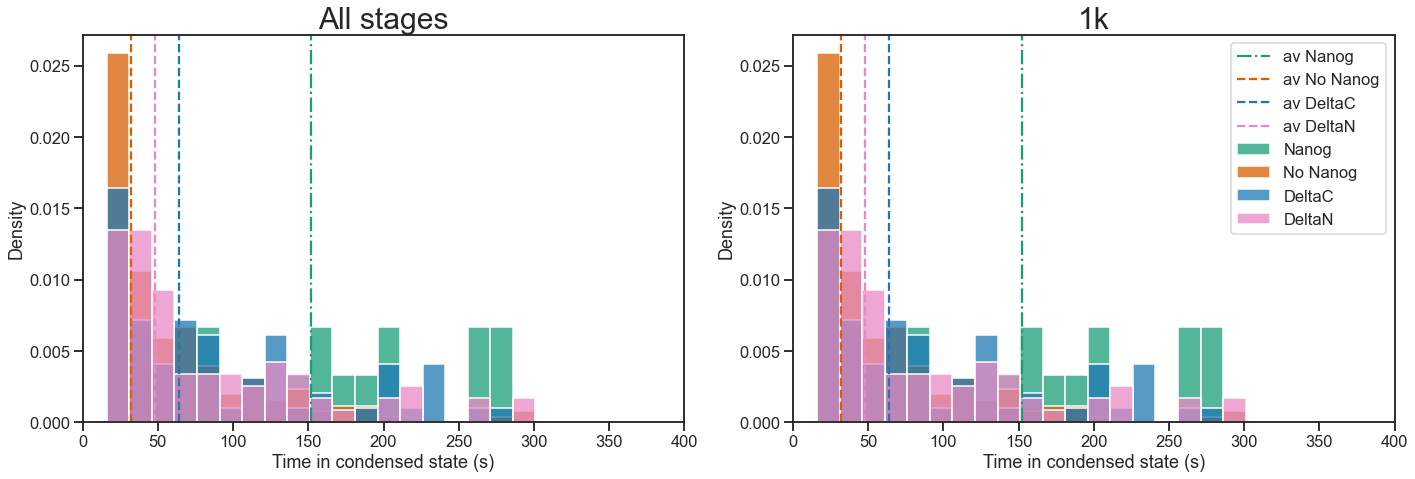

In [39]:
fig, ax = plt.subplots(ncols=len(stages_to_check),nrows=1,figsize=(10*len(stages_to_check),7))

i = 0
for stage in stages_to_check:

    # Get times sticked
    tau_stick_nanog = dict_nanog[stage]["TimeCondensedState(s)-ExcludingFlat"]
    tau_stick_no_nanog = dict_no_nanog[stage]["TimeCondensedState(s)-ExcludingFlat"]
    tau_stick_DeltaC = dict_DeltaC[stage]["TimeCondensedState(s)-ExcludingFlat"]
    tau_stick_DeltaN = dict_DeltaN[stage]["TimeCondensedState(s)-ExcludingFlat"]
    

        # Statistical test for Nanog and no Nanog
    U1, p_mw = stats.mannwhitneyu(tau_stick_nanog,tau_stick_no_nanog,alternative="greater")
    print("p-value Mann-Whitney U test: %f"%p_mw)
    
    stats_table = pd.concat([stats_table, pd.DataFrame({
                            'Measure': ["time in condensed state - excluding flat"],  # Wrap scalar values in lists
                            'Metric': ["-"],
                            'Stage': [stage],  # Ensure stage is a list
                            'p-value': [p_mw]  # Wrap p_mw in a list if it's a scalar
                            })], ignore_index=True)


    # Plot histograms
    ax[i].set_title(stage, fontsize=30)
    sns.histplot(ax=ax[i],data=pd.DataFrame({"nanog":tau_stick_nanog})["nanog"],stat="density",color=Cnanog,label="Nanog",binwidth=15)
    sns.histplot(ax=ax[i],data=pd.DataFrame({"no nanog":tau_stick_no_nanog})["no nanog"],stat="density",color=Cno_Nanog,label = "No Nanog",binwidth=15)
    sns.histplot(ax=ax[i],data=pd.DataFrame({"DeltaC":tau_stick_DeltaC})["DeltaC"],stat="density",color=CdeltaC,label = "DeltaC",binwidth=15)
    sns.histplot(ax=ax[i],data=pd.DataFrame({"DeltaN":tau_stick_DeltaN})["DeltaN"],stat="density",color=CdeltaN,label = "DeltaN",binwidth=15)
    ax[i].set_xlabel("Time in condensed state (s)")
    ax[i].axvline(x=np.median(tau_stick_nanog),color=Cnanog,linestyle='-.',label="av Nanog")
    ax[i].axvline(x=np.median(tau_stick_no_nanog),color=Cno_Nanog,linestyle='--',label="av No Nanog")
    ax[i].axvline(x=np.median(tau_stick_DeltaC),color=CdeltaC,linestyle='--',label="av DeltaC")
    ax[i].axvline(x=np.median(tau_stick_DeltaN),color=CdeltaN,linestyle='--',label="av DeltaN")
    ax[i].set_xlim([-0.01, 400])
    # ax[i].axvline(x=np.mean(tau_stick_nanog),color="blue",linestyle='-',label="mean Nanog")
    # ax[i].axvline(x=np.mean(tau_stick_no_nanog),color="orange",linestyle='-',label="mean No Nanog")
    i+=1
    
ax[i-1].legend()
plt.tight_layout()

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.savefig('TimeNoFlat'+'.png')
plt.show()

In [40]:
print("Median No Nanog, Nanog and DeltaC: "+ str(np.median(tau_stick_no_nanog)) +", " +  str(np.median(tau_stick_nanog))+", "+ str( np.median(tau_stick_DeltaC))+", "+ str( np.median(tau_stick_DeltaN)))

Median No Nanog, Nanog and DeltaC: 32.0, 152.0, 64.0, 48.0


## Save p-values to file

In [41]:
stats_table.to_csv("hp_tests.csv",index=True,sep='\t')